In [1]:
from paths import models_folder, metadata_folder

In [2]:
from pyobsbox import ObsBoxGenerator

In [3]:
import logging
import keras
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [4]:
logging.getLogger("pyobsbox").setLevel(logging.INFO)

# List models

In [5]:
list(models_folder.glob('model_*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20756'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1024'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20608'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_time_dist_32_16_B1H_Inst_500'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_8_B1H_Inst_252'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_16_8_stride_4_B1H_Inst_253'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst_jorg'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_strid

In [6]:
model_path = models_folder / "model_conv_32_16_8_stride_4_B1H_Inst_center_scale_10_seed_42"

In [7]:
list(model_path.glob('*fetched*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_stride_4_B1H_Inst_center_scale_10_seed_42/validation_fetched.npy'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_stride_4_B1H_Inst_center_scale_10_seed_42/train_fetched.npy')]

# Load model and associated generators

In [8]:
model = keras.models.load_model(model_path)
model.summary()
model_metadata = json.load((model_path / "metadata.json").open('r'))
data_metadata_path = model_metadata["generator"]["metadata_path"]

# load the data metadata
data_metadata_df = pd.read_hdf(data_metadata_path)

# load the indices of the data seen by the model
train_seen_indices = np.load(model_path / "train_fetched.npy")
validation_seen_indices = np.load(model_path / "validation_fetched.npy")

# train/validation split
# train_split_indices = np.load(model_path / "train_split_indices.npy")
# validation_split_indices = np.load(model_path / "validation_split_indices.npy")

# load the data seen by the model
train_metadata = data_metadata_df.iloc[train_seen_indices]
validation_metadata = data_metadata_df.iloc[validation_seen_indices]

# the training loss history
hist = model_metadata["history"]

# remove shuffling
model_metadata["generator"]["shuffle"] = True  # True because I don't have the seen values indices
# create the generators
train_generator = ObsBoxGenerator(train_metadata,
                                  **model_metadata["generator"])
validation_generator = ObsBoxGenerator(validation_metadata,
                                       **model_metadata["generator"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 512, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 512, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 16)           3600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 8)             904       
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 128, 8)            456       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 8)            0

Feb/23 13:11:46 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Feb/23 13:11:46 pyobsbox.generator INFO: shuffle: True
Feb/23 13:11:46 pyobsbox.generator INFO: seed: 42
Feb/23 13:11:46 pyobsbox.generator INFO: batch_size: 8192
Feb/23 13:11:46 pyobsbox.generator INFO: sequence_length: 2048
Feb/23 13:11:46 pyobsbox.generator INFO: n_bunches: 256
Feb/23 13:11:46 pyobsbox.generator INFO: __len__: 1037
Feb/23 13:11:46 pyobsbox.generator INFO: fetched_log_folder: None
Feb/23 13:11:46 pyobsbox.generator INFO: fetched_log_prefix: 
Feb/23 13:11:46 pyobsbox.generator INFO: normalization: center_scale
Feb/23 13:11:46 pyobsbox.generator INFO: normalization_pre_split: False
Feb/23 13:11:46 pyobsbox.generator INFO: normalization_kwargs: {'scale_factor': 10}
Feb/23 13:11:46 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Feb/23 13:11:46 pyobsbox.g

In [9]:
print(train_metadata.shape)
train_metadata.head()

(265472, 11)


type  fill  beam plane  q           date_time  \
7245926  Inst  6919     1     h  7 2018-07-13 18:25:14   
6889344  Inst  7453     1     h  7 2018-11-18 06:39:21   
1617800  Inst  6663     1     h  7 2018-05-10 15:13:15   
6141910  Inst  6953     1     h  7 2018-07-21 06:32:07   
593647   Inst  6245     1     h  7 2017-09-26 15:54:15   

                                                      file  n_bunches  \
7245926  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/...       2556   
6889344  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7453/...        480   
1617800  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6663/...       2556   
6141910  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6953/...       2556   
593647   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/...       1916   

         bunch_index  bunch_number  ts_length  
7245926        147.0          91.0      65536  
6889344       1086.0         202.0      65536  
1617800       1901.0        1389.0      65536  
6141910        215.0         128.0      65536  
593647        2272.0        1254.0      65536

In [10]:
print(validation_metadata.shape)
validation_metadata.head()

(3840, 11)


type  fill  beam plane  q           date_time  \
2475699   Inst  6272     1     h  7 2017-10-05 13:21:13   
6303939   Inst  6362     1     h  7 2017-11-04 22:52:14   
7653709   Inst  7378     1     h  7 2018-10-29 00:00:14   
11480497  Inst  7464     1     h  7 2018-11-22 05:05:14   
7105832   Inst  6275     1     h  7 2017-10-06 01:10:15   

                                                       file  n_bunches  \
2475699   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/...       1836   
6303939   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6362/...       1868   
7653709   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7378/...        456   
11480497  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7464/...        460   
7105832   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6275/...       1868   

          bunch_index  bunch_number  ts_length  
2475699        2586.0        1371.0      65536  
6303939         928.0         493.0      65536  
7653709        1408.0         428.0      65536  
11480497       2151.0         258.0      65536  
7105832         957.0         514.0      65536

# Loss functions

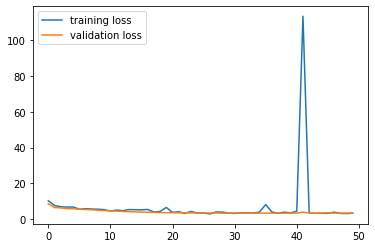

In [11]:
plt.plot(hist['loss'], label='training loss')
plt.plot(hist['val_loss'], label='validation loss')
plt.legend()

# Datasets

Load the first few batches

In [12]:
train_dataset = np.vstack([train_generator[i][0] for i in tqdm(range(50))])
train_dataset.shape

(409600, 2048, 1)

In [13]:
validation_dataset = np.vstack([validation_generator[i][0] for i in tqdm(range(5))])
validation_dataset.shape

(40960, 2048, 1)

# Predictions

In [14]:
train_pred = model.predict(train_dataset, verbose=1, batch_size=train_generator.batch_size)
train_pred.shape

50/50 [==============================] - 69s 1s/step


(409600, 2048, 1)

In [15]:
validation_pred = model.predict(validation_dataset, verbose=1, batch_size=validation_generator.batch_size)
validation_pred.shape

5/5 [==============================] - 4s 837ms/step


(40960, 2048, 1)

In [16]:
MAE_train = abs(train_pred - train_dataset).mean(axis=1).squeeze()
MAE_train.shape

(409600,)

In [17]:
MAE_validation = abs(validation_pred - validation_dataset).mean(axis=1).squeeze()
MAE_validation.shape

(40960,)

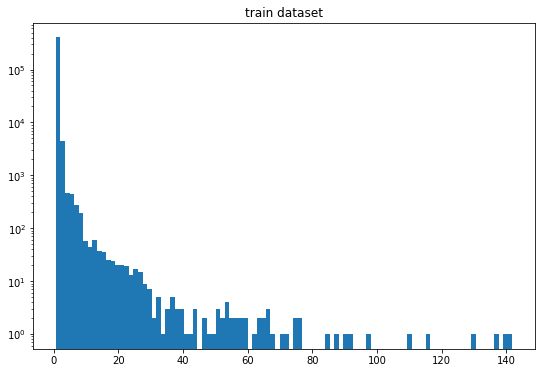

In [18]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_train, bins=100)
plt.title("train dataset")
plt.yscale('log')

rough peak

In [19]:
hist_peak_train = bins[n.argmax()]
hist_peak_train

0.701135572882049

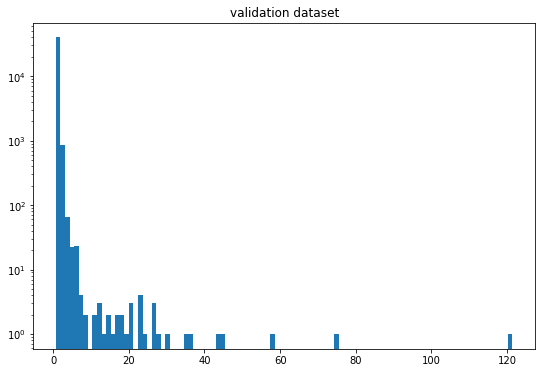

In [20]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_validation, bins=100)
plt.title("validation dataset")
plt.yscale('log')

In [21]:
hist_peak_validation = bins[n.argmax()]
hist_peak_validation

0.7239080733103038

In [22]:
max_MAE_indices = np.argsort(MAE_train)[::-1]

In [23]:
max_MAE_indices

array([356849, 355586, 359817, ..., 290164, 322419,  73857])

In [24]:
def plot_true_pred(true_signal, pred_signal):
    fig, axes = plt.subplots(2, figsize=(16, 6))
    axes[0].plot(true_signal)
    axes[0].plot(pred_signal)

    axes[1].plot(np.abs(np.diff(true_signal)))
    axes[1].plot(np.abs(np.diff(pred_signal)))
    return fig, axes

index:  356849
MAE:  141.8414837383374
n_bunches       780
bunch_index     603
bunch_number    407
Name: 719870, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6761/instability_data/06761_Inst_B1H_Q7_20180605_19h10m35s.h5


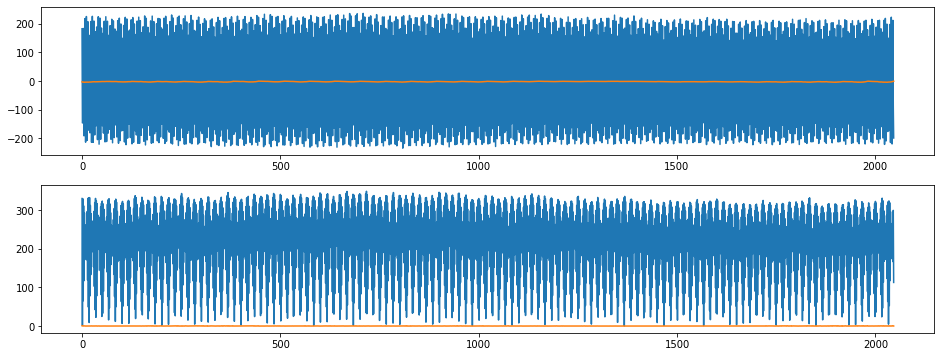

In [25]:
anomalous = 0
anomalous_index = max_MAE_indices[anomalous]

print('index: ', anomalous_index)
print("MAE: ", MAE_train[anomalous_index])
# I'm not sure this row is correct
metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
print(metadata_row['file'])

true_signal = train_dataset[anomalous_index].squeeze()
pred_signal = train_pred[anomalous_index].squeeze()

plot_true_pred(true_signal, pred_signal);

# Top rightmost signals

index:  356849
MAE:  141.8414837383374
n_bunches       780
bunch_index     603
bunch_number    407
Name: 719870, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6761/instability_data/06761_Inst_B1H_Q7_20180605_19h10m35s.h5


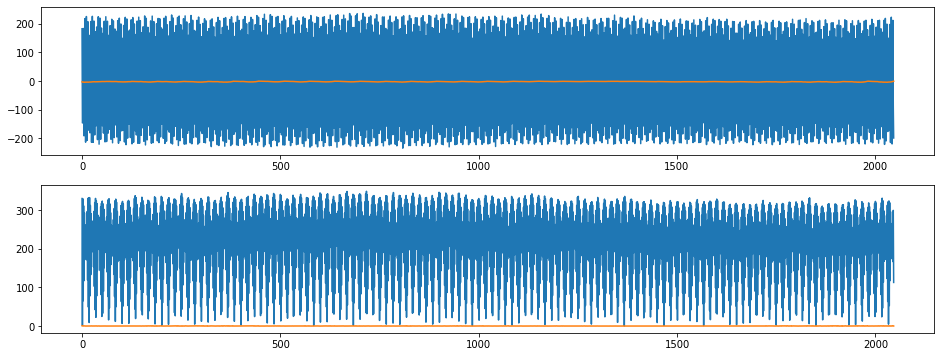

index:  355586
MAE:  139.5113127550663
n_bunches       108
bunch_index      77
bunch_number     28
Name: 7725680, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7090/instability_data/07090_Inst_B1H_Q7_20180826_10h03m32s.h5


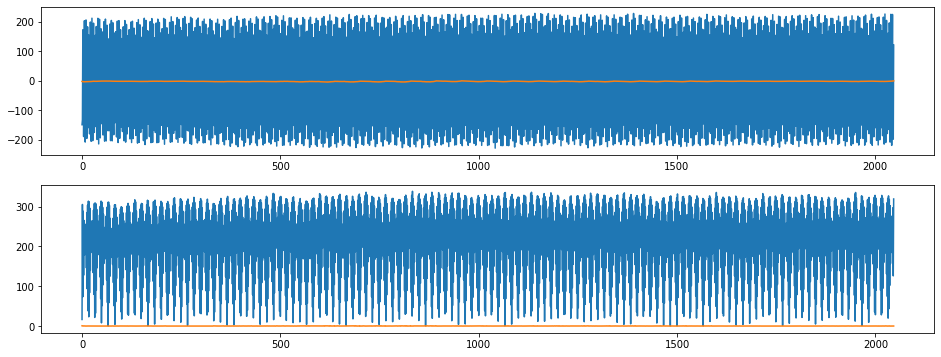

index:  359817
MAE:  136.8761223933776
n_bunches        656
bunch_index     2276
bunch_number     432
Name: 2986712, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6404/instability_data/06404_Inst_B1H_Q7_20171121_18h23m14s.h5


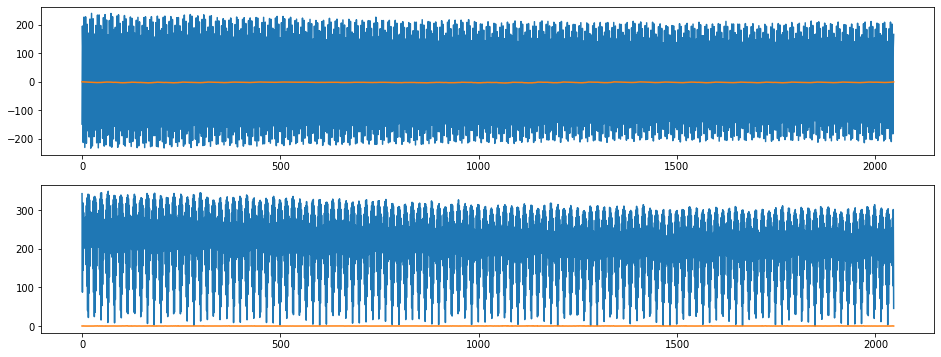

index:  353559
MAE:  129.23259305610554
n_bunches       1308
bunch_index     1284
bunch_number     930
Name: 1846339, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7056/instability_data/07056_Inst_B1H_Q7_20180815_03h07m56s.h5


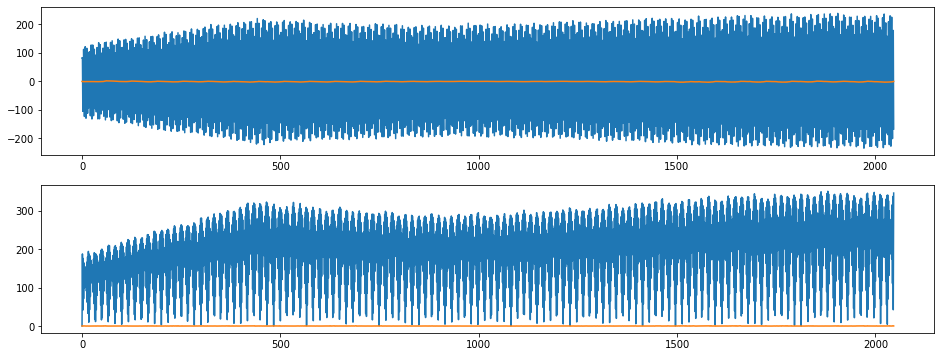

index:  332842
MAE:  115.66085810822551
n_bunches       1452
bunch_index      702
bunch_number     292
Name: 275332, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180706_11h41m15s.h5


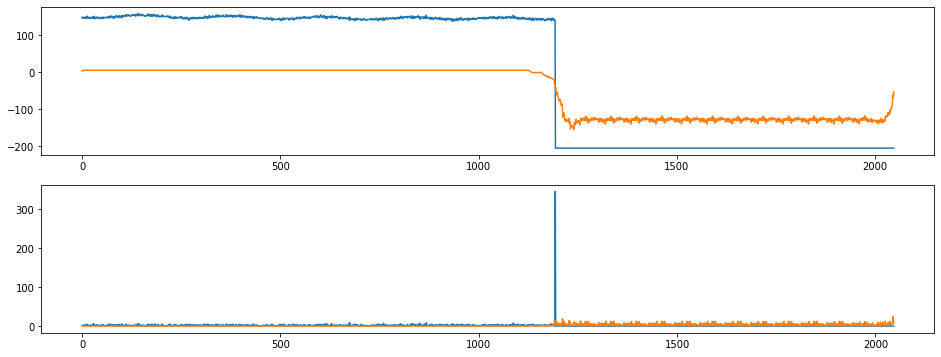

index:  127570
MAE:  109.40146021306282
n_bunches       1836
bunch_index     1225
bunch_number     649
Name: 3307945, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6271/instability_data/06271_Inst_B1H_Q7_20171004_11h54m55s.h5


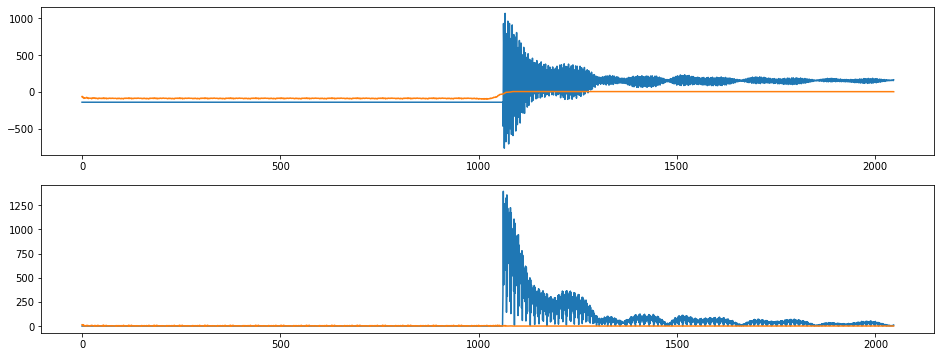

index:  357938
MAE:  97.59882953064516
n_bunches       418
bunch_index     452
bunch_number     92
Name: 1839325, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7489/instability_data/07489_Inst_B1H_Q7_20181201_17h24m18s.h5


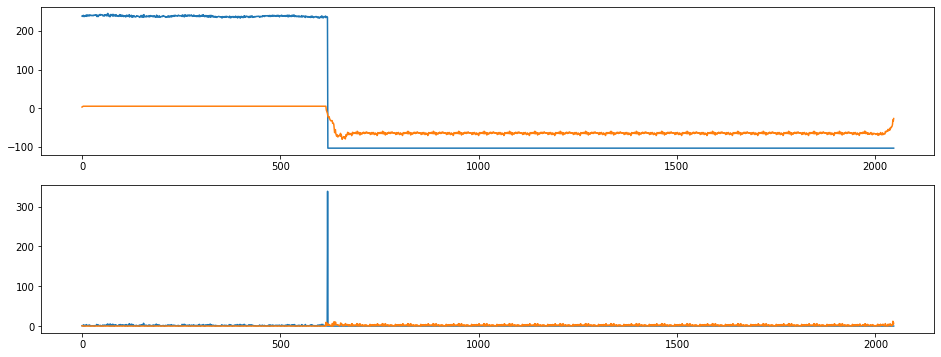

index:  154239
MAE:  91.65181968334363
n_bunches       1116
bunch_index     1019
bunch_number     392
Name: 7574998, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6587/instability_data/06587_Inst_B1H_Q7_20180421_15h05m14s.h5


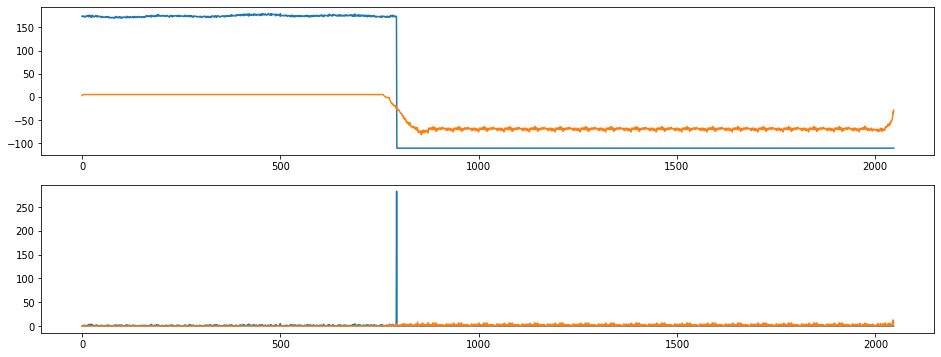

index:  287663
MAE:  90.50422252526621
n_bunches       252
bunch_index     326
bunch_number    225
Name: 3528520, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7063/instability_data/07063_Inst_B1H_Q7_20180818_14h46m15s.h5


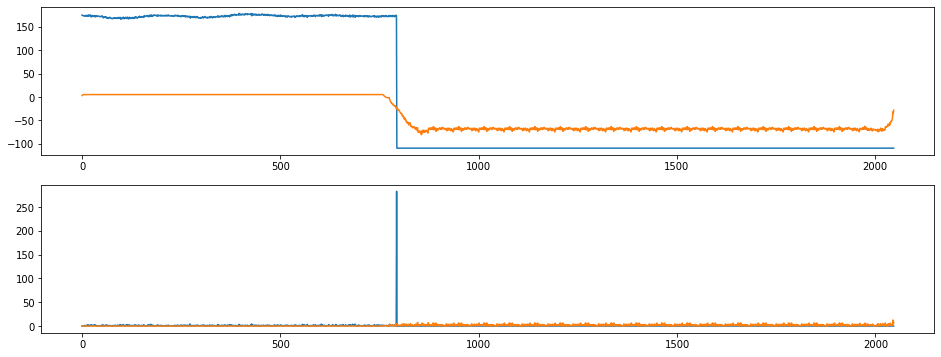

index:  144944
MAE:  87.65530672851601
n_bunches       1916
bunch_index       81
bunch_number      35
Name: 500832, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6253/instability_data/06253_Inst_B1H_Q7_20170929_03h32m15s.h5


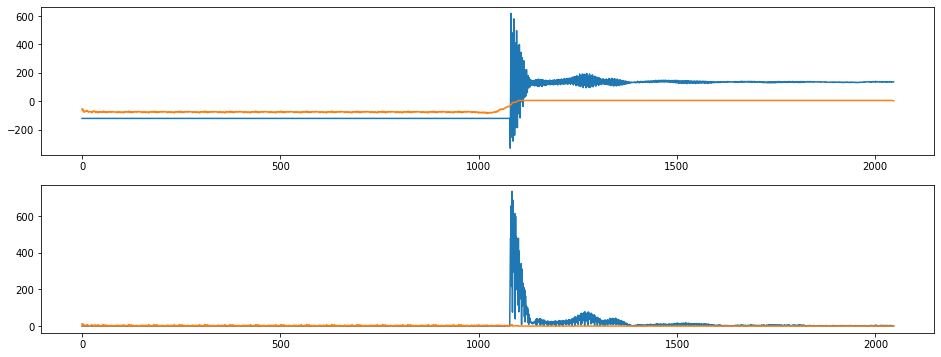

In [26]:
for i in range(10):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Top leftmost signals

index:  73857
MAE:  0.701135572882049
n_bunches       1868
bunch_index      418
bunch_number     219
Name: 9276575, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6279/instability_data/06279_Inst_B1H_Q7_20171007_10h50m14s.h5


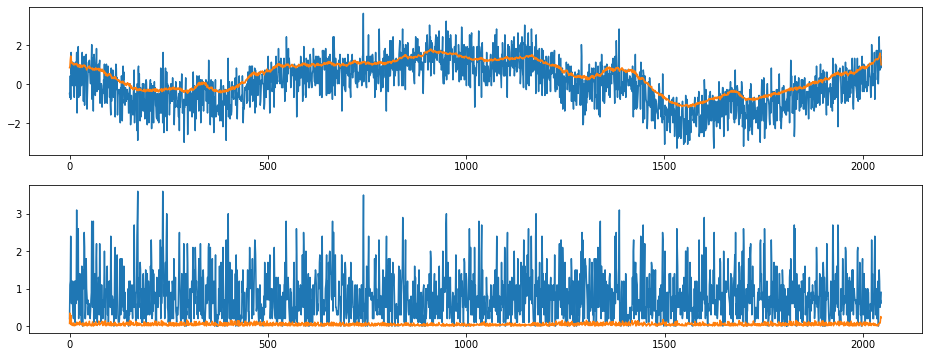

index:  322419
MAE:  0.706788032073382
n_bunches        733
bunch_index     2737
bunch_number     575
Name: 7118460, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7480/instability_data/07480_Inst_B1H_Q7_20181128_00h37m15s.h5


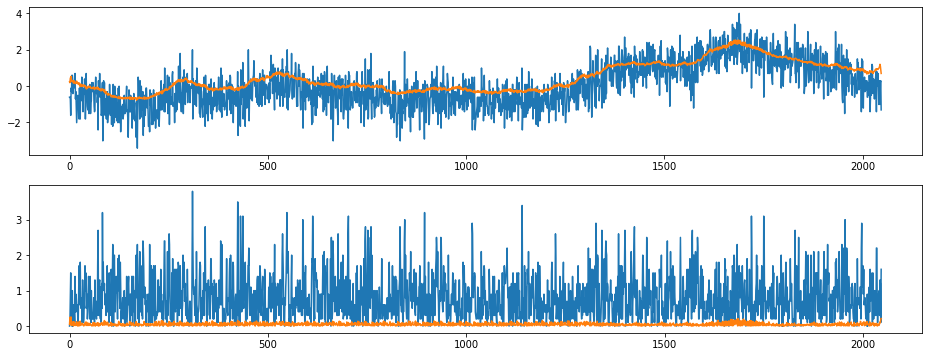

index:  290164
MAE:  0.7084143531617884
n_bunches       780
bunch_index     310
bunch_number    209
Name: 10543071, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7325/instability_data/07325_Inst_B1H_Q7_20181021_19h01m57s.h5


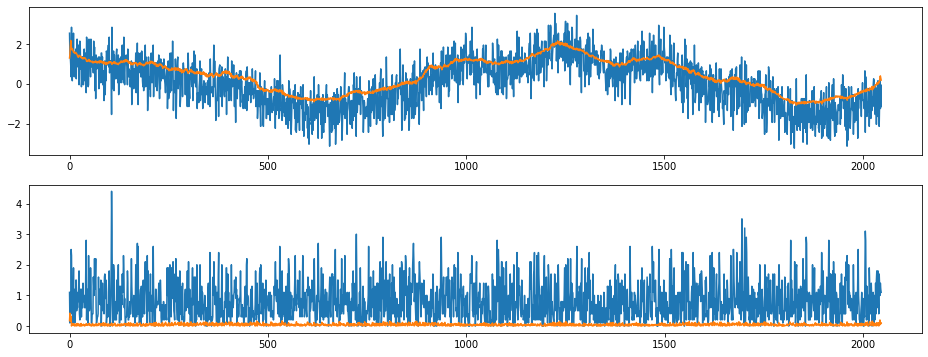

index:  81525
MAE:  0.7096179778316583
n_bunches       1551
bunch_index     2063
bunch_number     900
Name: 2989870, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6628/instability_data/06628_Inst_B1H_Q7_20180430_21h36m14s.h5


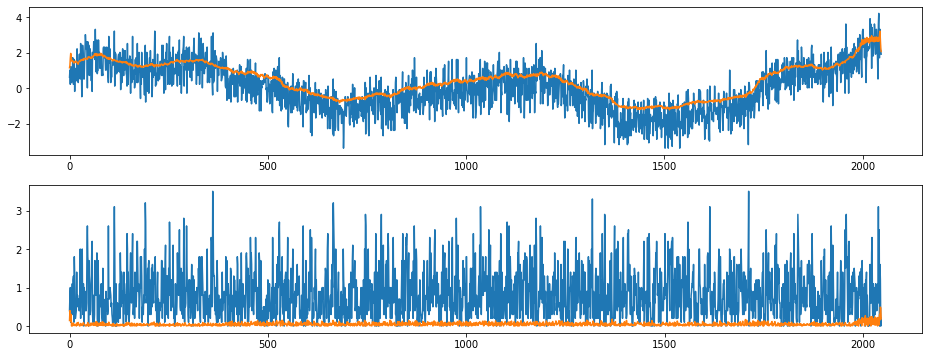

index:  75094
MAE:  0.7106505997136991
n_bunches       1068
bunch_index     1298
bunch_number     944
Name: 4179255, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6773/instability_data/06773_Inst_B1H_Q7_20180610_07h24m09s.h5


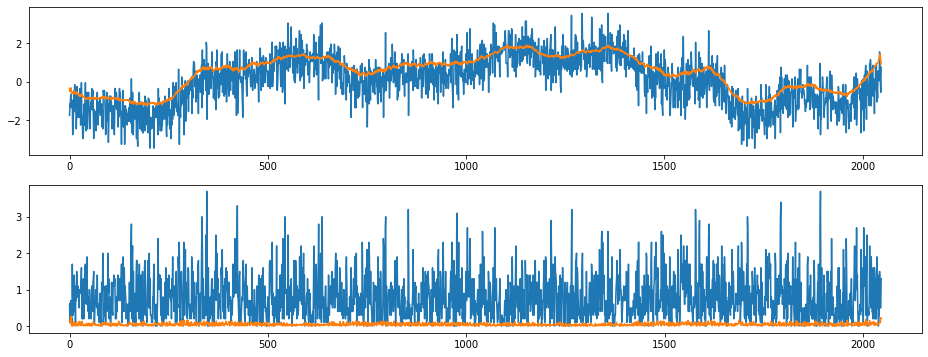

index:  128749
MAE:  0.712457370069751
n_bunches       1887
bunch_index      516
bunch_number     371
Name: 2281822, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6629/instability_data/06629_Inst_B1H_Q7_20180501_16h28m14s.h5


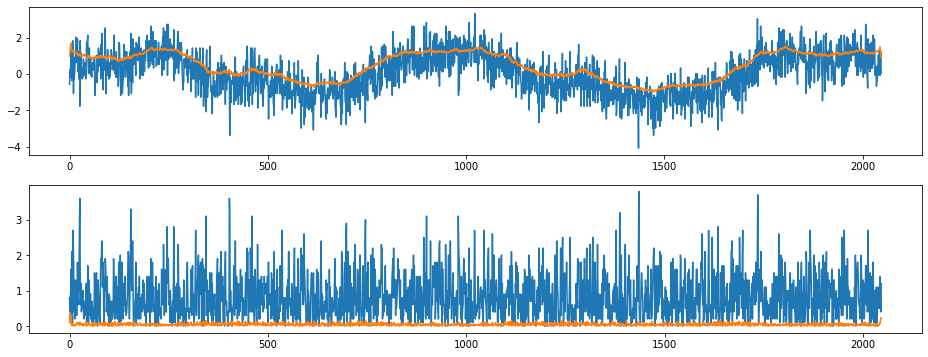

index:  245208
MAE:  0.7136408568141632
n_bunches       780
bunch_index     313
bunch_number    200
Name: 144730, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6702/instability_data/06702_Inst_B1H_Q7_20180519_21h57m14s.h5


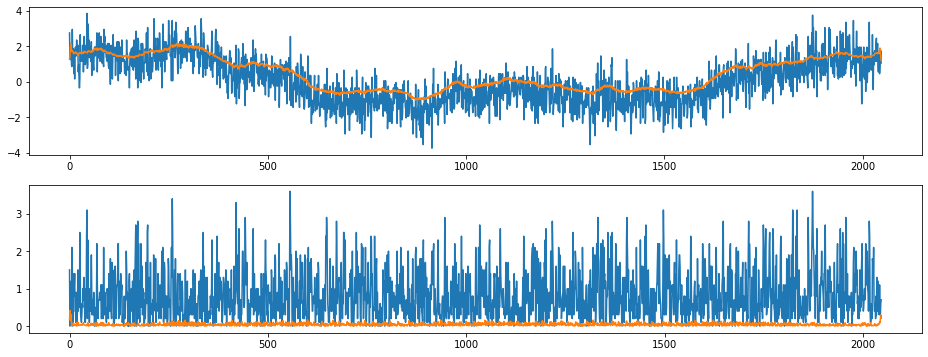

index:  76264
MAE:  0.713833780965797
n_bunches       229
bunch_index     267
bunch_number     52
Name: 1788442, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7468/instability_data/07468_Inst_B1H_Q7_20181123_19h21m50s.h5


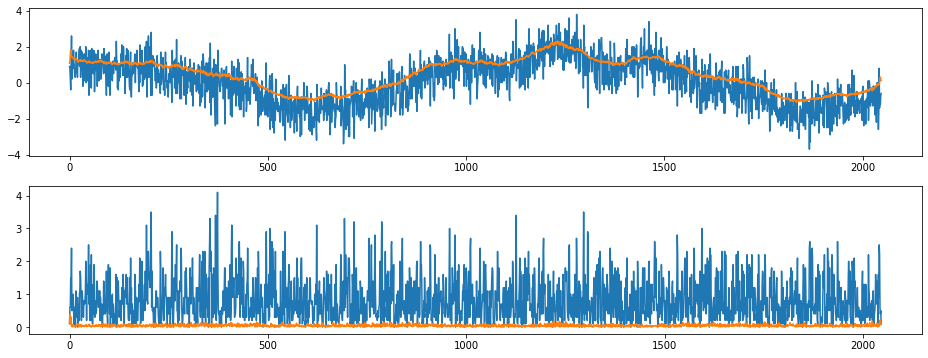

index:  323916
MAE:  0.71467271985166
n_bunches       2556
bunch_index     2527
bunch_number    1873
Name: 2338447, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6696/instability_data/06696_Inst_B1H_Q7_20180518_10h05m14s.h5


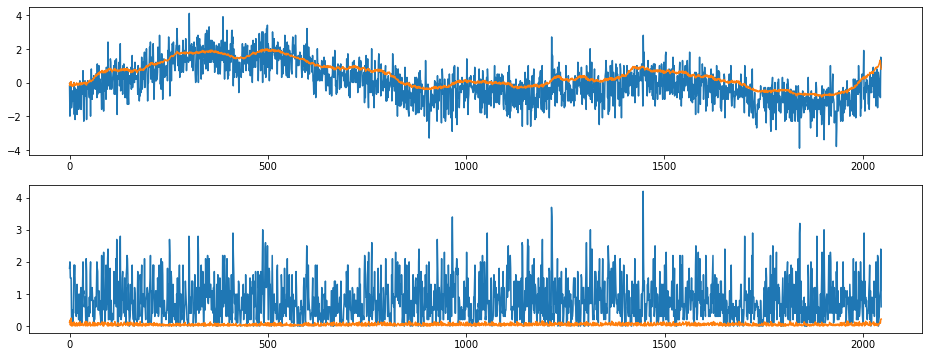

index:  80310
MAE:  0.7170491603719711
n_bunches       540
bunch_index     122
bunch_number     66
Name: 4119931, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7015/instability_data/07015_Inst_B1H_Q7_20180803_06h18m14s.h5


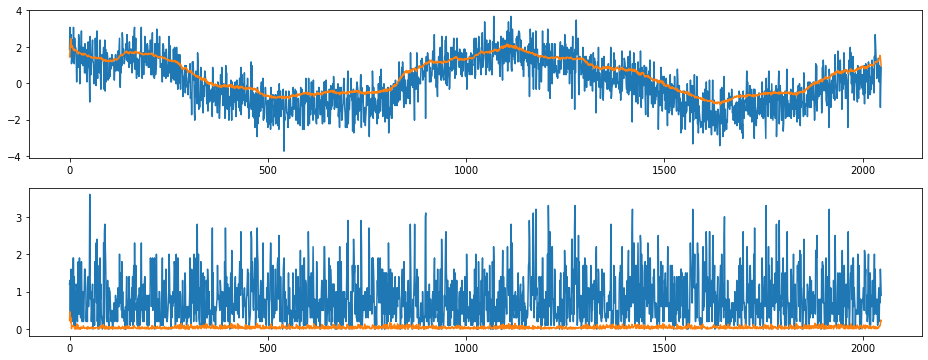

In [27]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Signals around the peak

In [28]:
around_peak_indices = np.argsort(np.abs(MAE_train - hist_peak_train))

index:  73857
MAE:  0.701135572882049
n_bunches       1868
bunch_index      418
bunch_number     219
Name: 9276575, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6279/instability_data/06279_Inst_B1H_Q7_20171007_10h50m14s.h5


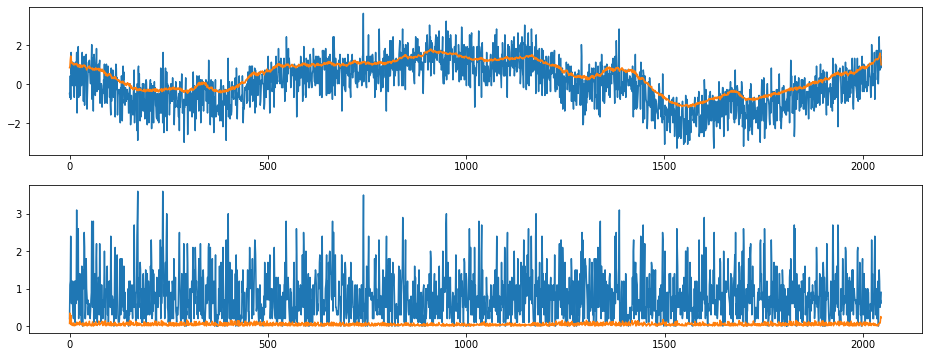

index:  322419
MAE:  0.706788032073382
n_bunches        733
bunch_index     2737
bunch_number     575
Name: 7118460, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7480/instability_data/07480_Inst_B1H_Q7_20181128_00h37m15s.h5


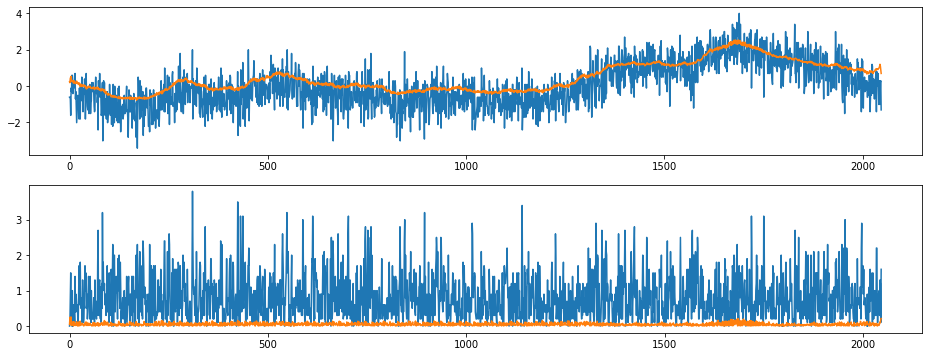

index:  290164
MAE:  0.7084143531617884
n_bunches       780
bunch_index     310
bunch_number    209
Name: 10543071, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7325/instability_data/07325_Inst_B1H_Q7_20181021_19h01m57s.h5


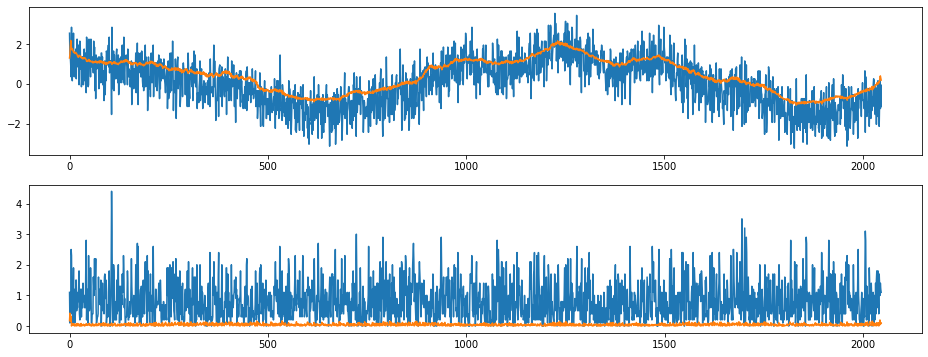

index:  81525
MAE:  0.7096179778316583
n_bunches       1551
bunch_index     2063
bunch_number     900
Name: 2989870, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6628/instability_data/06628_Inst_B1H_Q7_20180430_21h36m14s.h5


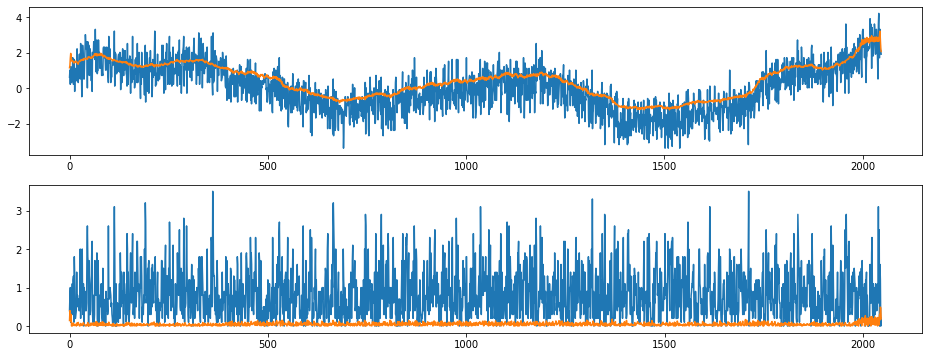

index:  75094
MAE:  0.7106505997136991
n_bunches       1068
bunch_index     1298
bunch_number     944
Name: 4179255, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6773/instability_data/06773_Inst_B1H_Q7_20180610_07h24m09s.h5


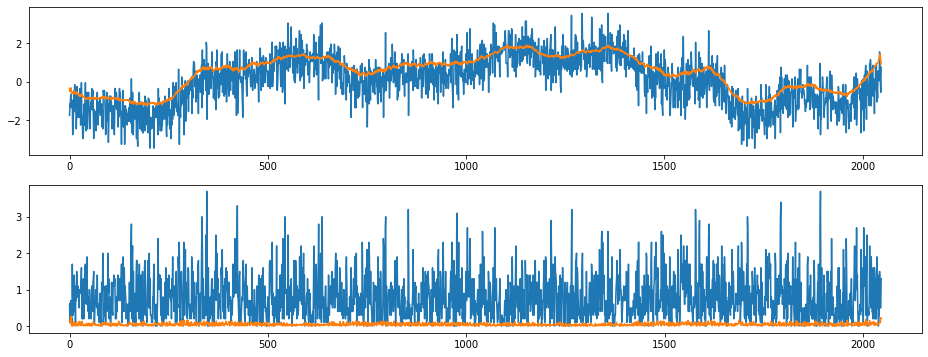

index:  128749
MAE:  0.712457370069751
n_bunches       1887
bunch_index      516
bunch_number     371
Name: 2281822, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6629/instability_data/06629_Inst_B1H_Q7_20180501_16h28m14s.h5


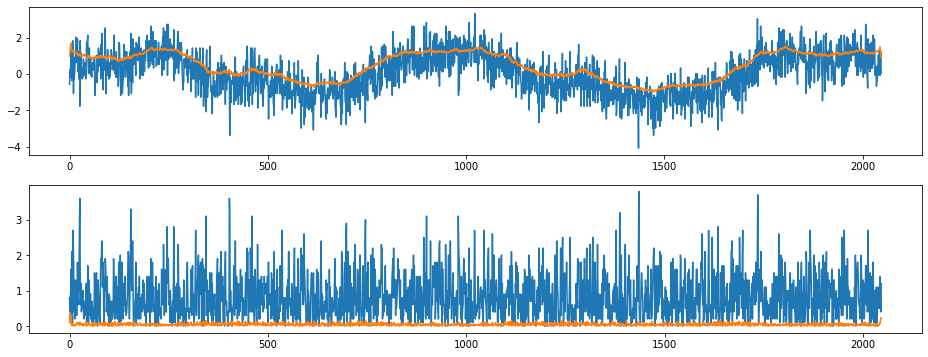

index:  245208
MAE:  0.7136408568141632
n_bunches       780
bunch_index     313
bunch_number    200
Name: 144730, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6702/instability_data/06702_Inst_B1H_Q7_20180519_21h57m14s.h5


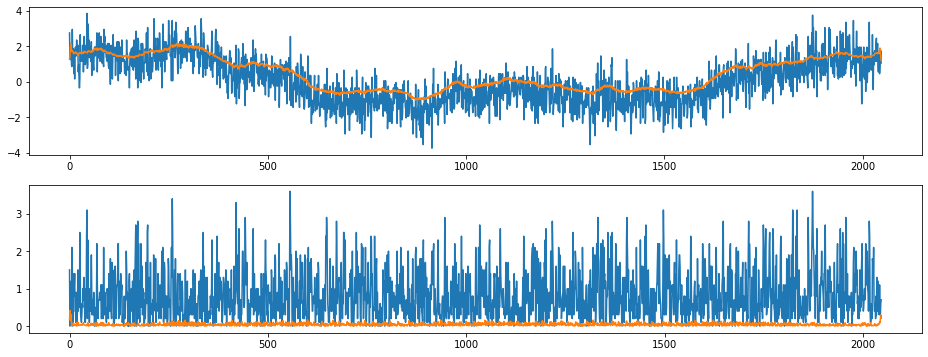

index:  76264
MAE:  0.713833780965797
n_bunches       229
bunch_index     267
bunch_number     52
Name: 1788442, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7468/instability_data/07468_Inst_B1H_Q7_20181123_19h21m50s.h5


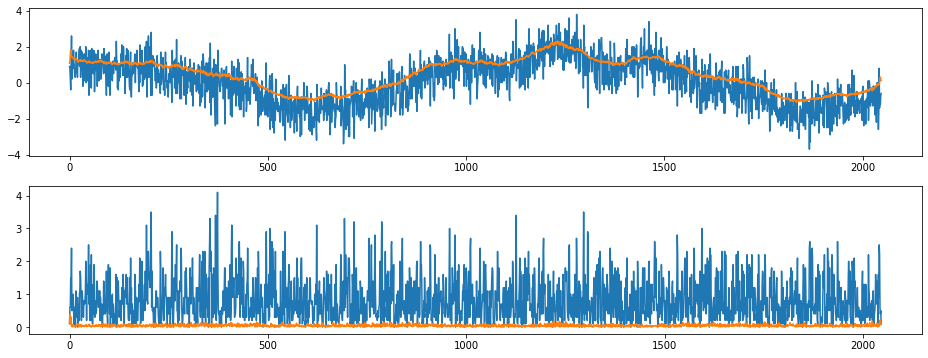

index:  323916
MAE:  0.71467271985166
n_bunches       2556
bunch_index     2527
bunch_number    1873
Name: 2338447, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6696/instability_data/06696_Inst_B1H_Q7_20180518_10h05m14s.h5


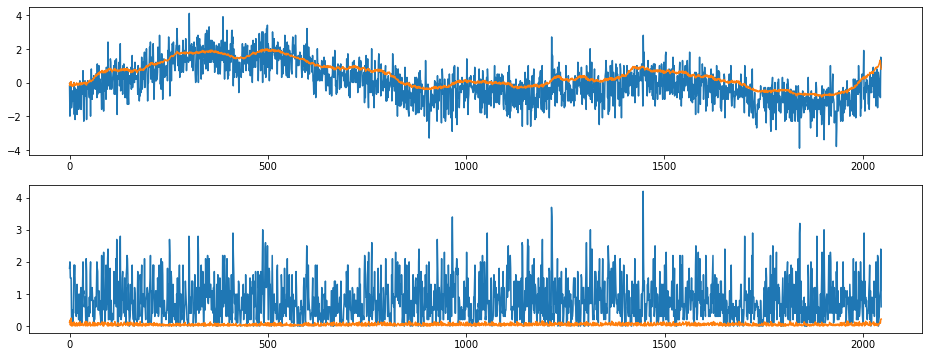

index:  80310
MAE:  0.7170491603719711
n_bunches       540
bunch_index     122
bunch_number     66
Name: 4119931, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7015/instability_data/07015_Inst_B1H_Q7_20180803_06h18m14s.h5


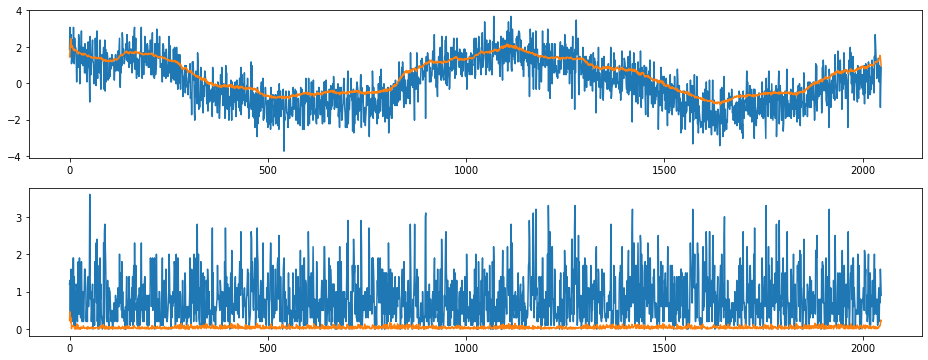

In [29]:
for i in range(10):
    around_peak_index = around_peak_indices[i]

    print('index: ', around_peak_index)
    print("MAE: ", MAE_train[around_peak_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_peak_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_peak_index].squeeze()
    pred_signal = train_pred[around_peak_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# around a point

In [30]:
around_point_indices = np.argsort(np.abs(MAE_train - 0.6))

index:  73857
MAE:  0.701135572882049
n_bunches       1868
bunch_index      418
bunch_number     219
Name: 9276575, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6279/instability_data/06279_Inst_B1H_Q7_20171007_10h50m14s.h5


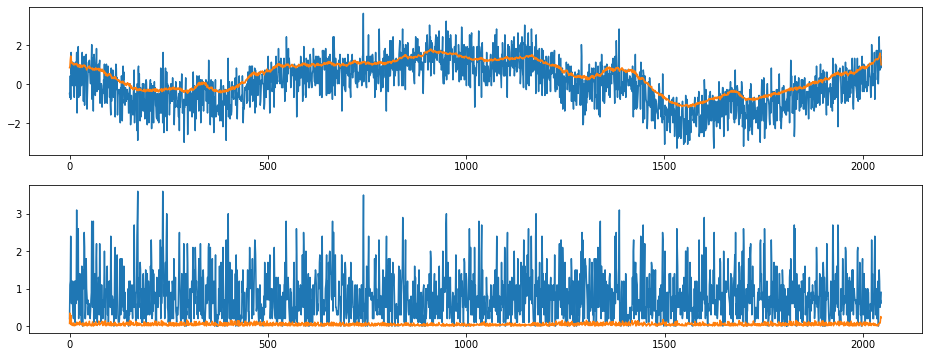

index:  322419
MAE:  0.706788032073382
n_bunches        733
bunch_index     2737
bunch_number     575
Name: 7118460, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7480/instability_data/07480_Inst_B1H_Q7_20181128_00h37m15s.h5


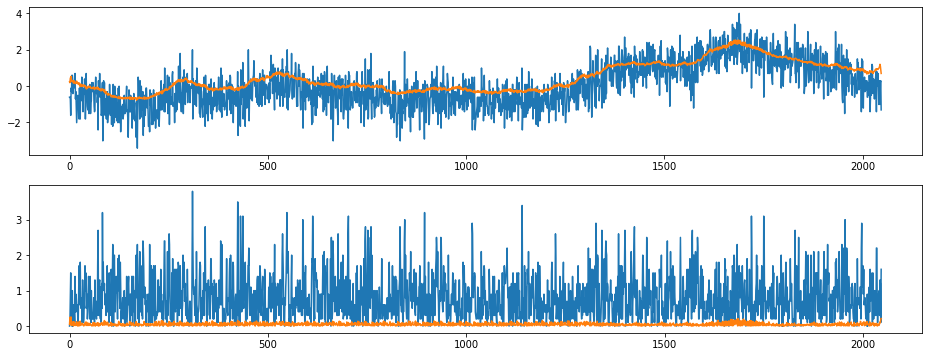

index:  290164
MAE:  0.7084143531617884
n_bunches       780
bunch_index     310
bunch_number    209
Name: 10543071, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7325/instability_data/07325_Inst_B1H_Q7_20181021_19h01m57s.h5


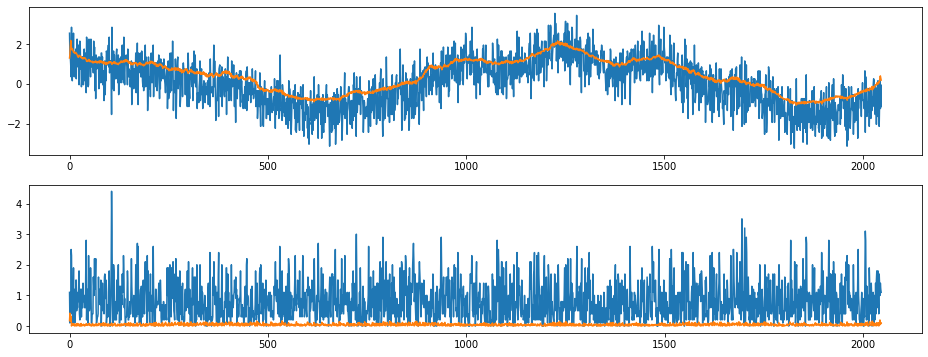

index:  81525
MAE:  0.7096179778316583
n_bunches       1551
bunch_index     2063
bunch_number     900
Name: 2989870, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6628/instability_data/06628_Inst_B1H_Q7_20180430_21h36m14s.h5


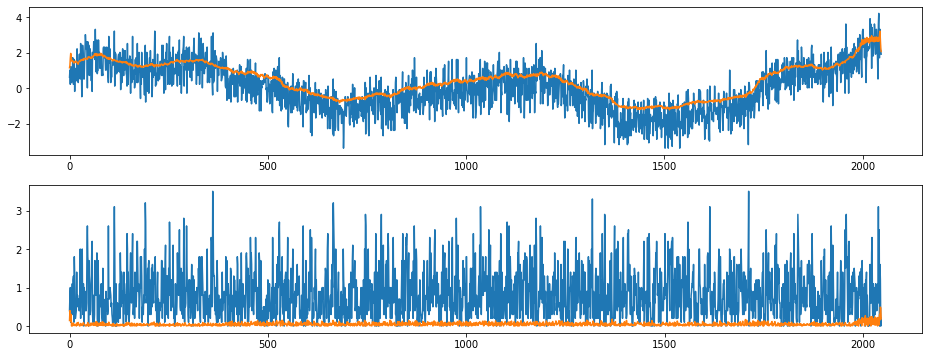

index:  75094
MAE:  0.7106505997136991
n_bunches       1068
bunch_index     1298
bunch_number     944
Name: 4179255, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6773/instability_data/06773_Inst_B1H_Q7_20180610_07h24m09s.h5


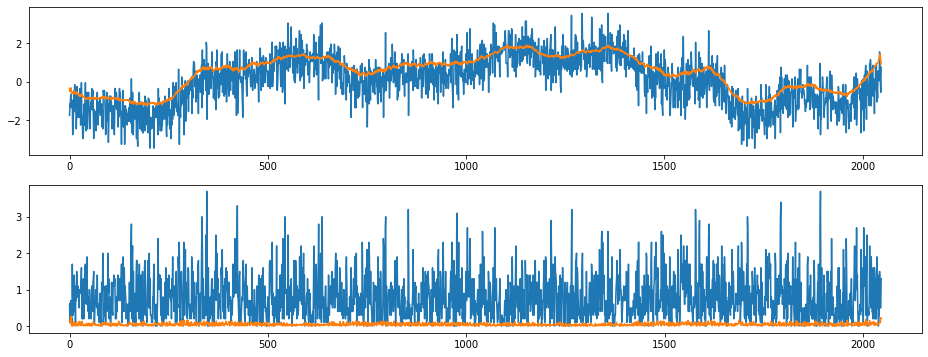

index:  128749
MAE:  0.712457370069751
n_bunches       1887
bunch_index      516
bunch_number     371
Name: 2281822, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6629/instability_data/06629_Inst_B1H_Q7_20180501_16h28m14s.h5


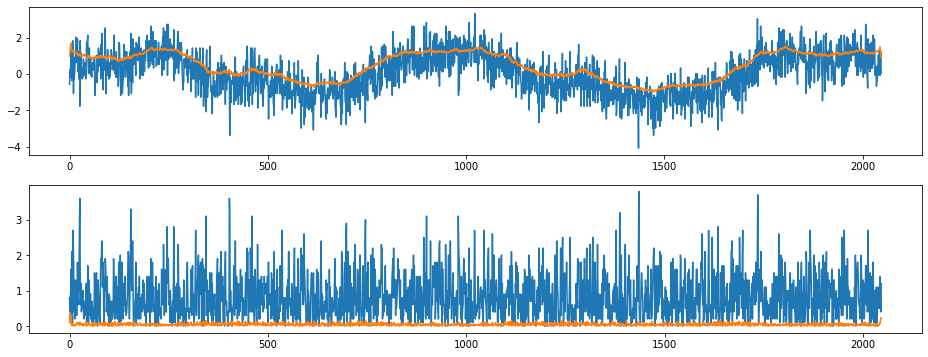

index:  245208
MAE:  0.7136408568141632
n_bunches       780
bunch_index     313
bunch_number    200
Name: 144730, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6702/instability_data/06702_Inst_B1H_Q7_20180519_21h57m14s.h5


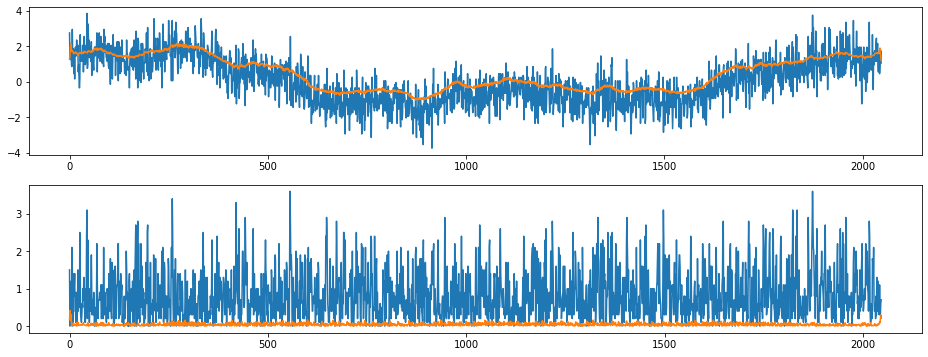

index:  76264
MAE:  0.713833780965797
n_bunches       229
bunch_index     267
bunch_number     52
Name: 1788442, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7468/instability_data/07468_Inst_B1H_Q7_20181123_19h21m50s.h5


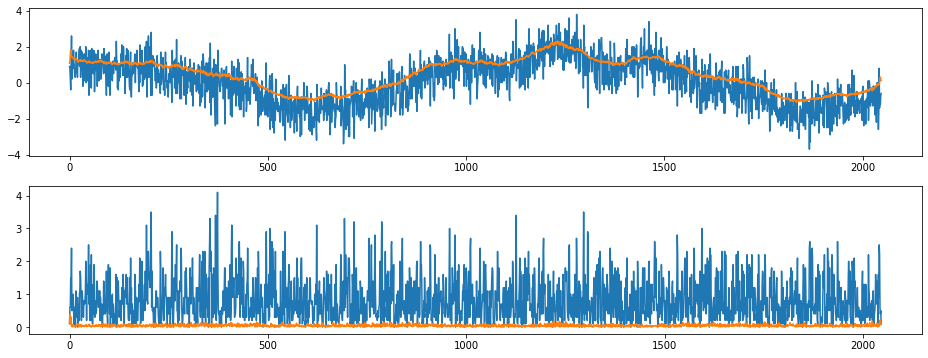

index:  323916
MAE:  0.71467271985166
n_bunches       2556
bunch_index     2527
bunch_number    1873
Name: 2338447, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6696/instability_data/06696_Inst_B1H_Q7_20180518_10h05m14s.h5


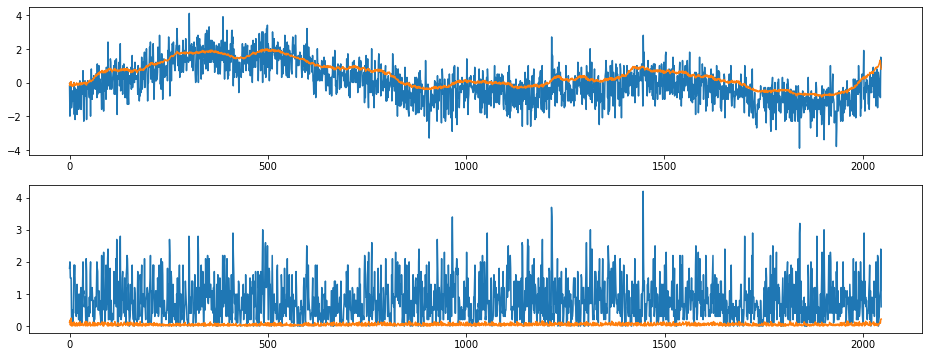

index:  80310
MAE:  0.7170491603719711
n_bunches       540
bunch_index     122
bunch_number     66
Name: 4119931, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7015/instability_data/07015_Inst_B1H_Q7_20180803_06h18m14s.h5


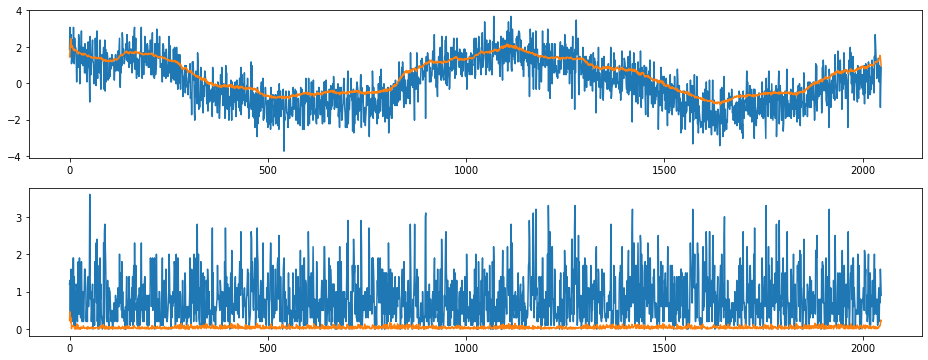

In [31]:
for i in range(10):
    around_point_index = around_point_indices[i]

    print('index: ', around_point_index)
    print("MAE: ", MAE_train[around_point_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_point_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_point_index].squeeze()
    pred_signal = train_pred[around_point_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# latent space encoding

In [32]:
import keras

In [33]:
encoding_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer('conv1d_2').output)

In [34]:
encoding_output = encoding_model(train_dataset[max_MAE_indices[-1]][None, :])
encoding_output.shape

TensorShape([1, 32, 8])

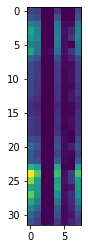

In [35]:
plt.imshow(np.array(encoding_output).squeeze())

# Latent space encoding of nominal signals

index:  73857
MAE:  0.701135572882049
n_bunches       1868
bunch_index      418
bunch_number     219
Name: 9276575, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6279/instability_data/06279_Inst_B1H_Q7_20171007_10h50m14s.h5


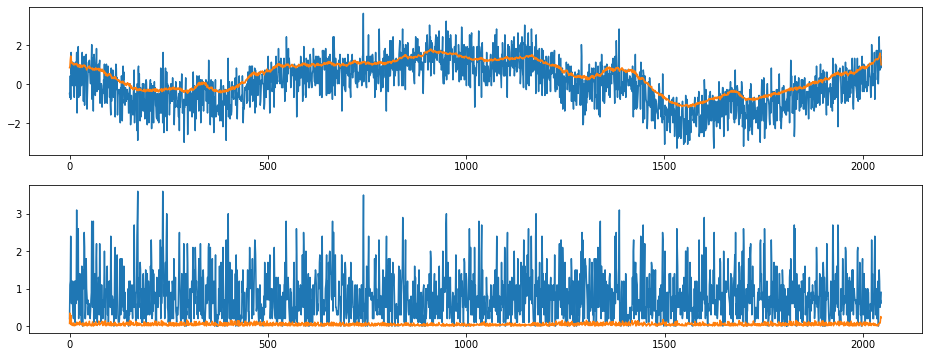

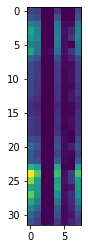

index:  322419
MAE:  0.706788032073382
n_bunches        733
bunch_index     2737
bunch_number     575
Name: 7118460, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7480/instability_data/07480_Inst_B1H_Q7_20181128_00h37m15s.h5


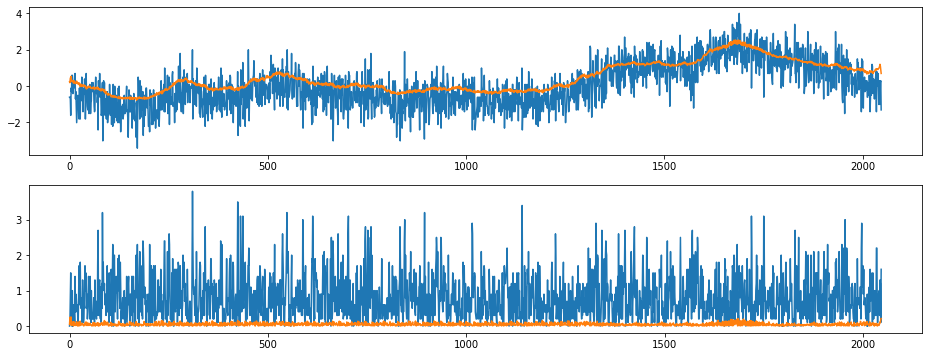

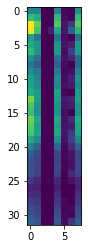

index:  290164
MAE:  0.7084143531617884
n_bunches       780
bunch_index     310
bunch_number    209
Name: 10543071, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7325/instability_data/07325_Inst_B1H_Q7_20181021_19h01m57s.h5


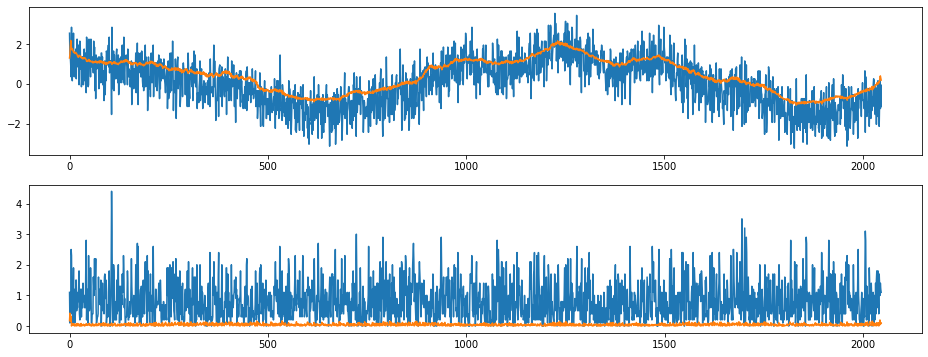

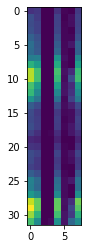

index:  81525
MAE:  0.7096179778316583
n_bunches       1551
bunch_index     2063
bunch_number     900
Name: 2989870, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6628/instability_data/06628_Inst_B1H_Q7_20180430_21h36m14s.h5


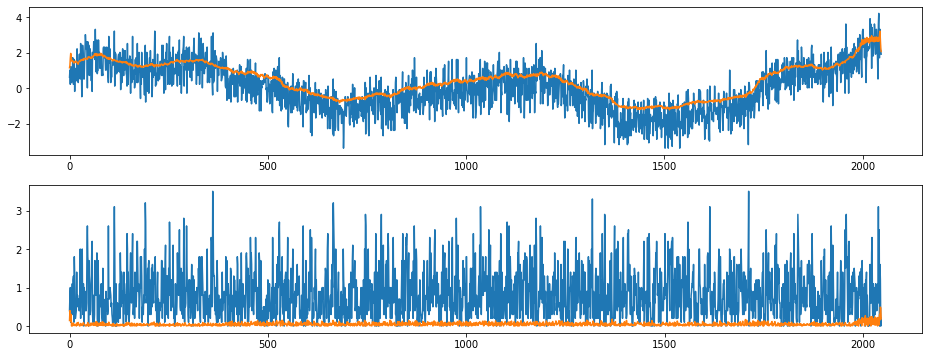

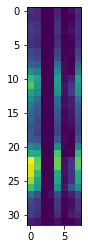

index:  75094
MAE:  0.7106505997136991
n_bunches       1068
bunch_index     1298
bunch_number     944
Name: 4179255, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6773/instability_data/06773_Inst_B1H_Q7_20180610_07h24m09s.h5


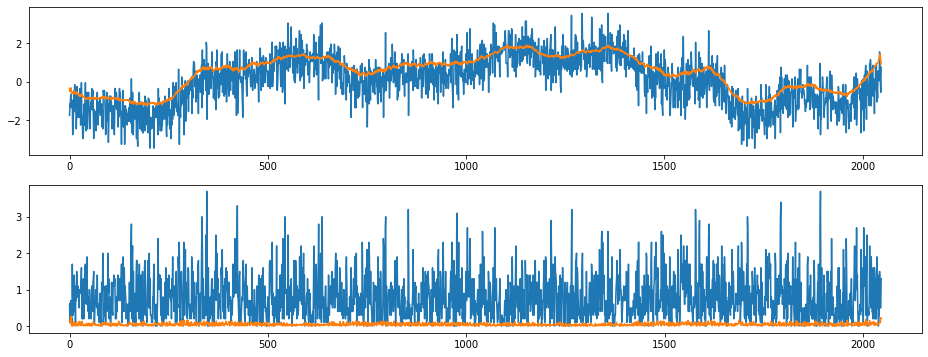

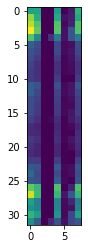

index:  128749
MAE:  0.712457370069751
n_bunches       1887
bunch_index      516
bunch_number     371
Name: 2281822, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6629/instability_data/06629_Inst_B1H_Q7_20180501_16h28m14s.h5


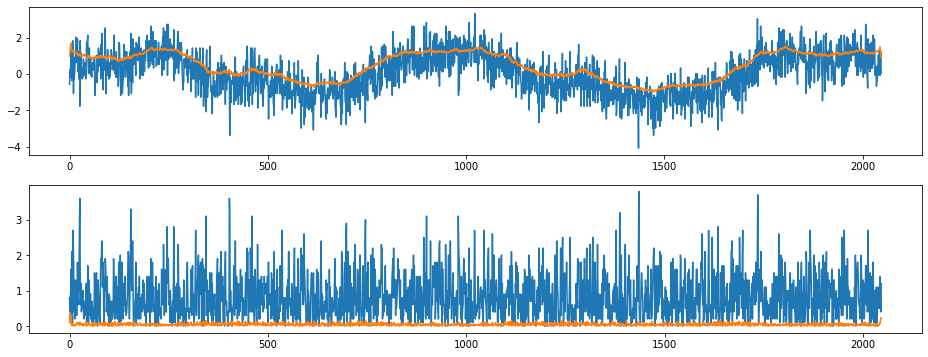

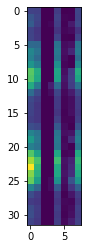

index:  245208
MAE:  0.7136408568141632
n_bunches       780
bunch_index     313
bunch_number    200
Name: 144730, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6702/instability_data/06702_Inst_B1H_Q7_20180519_21h57m14s.h5


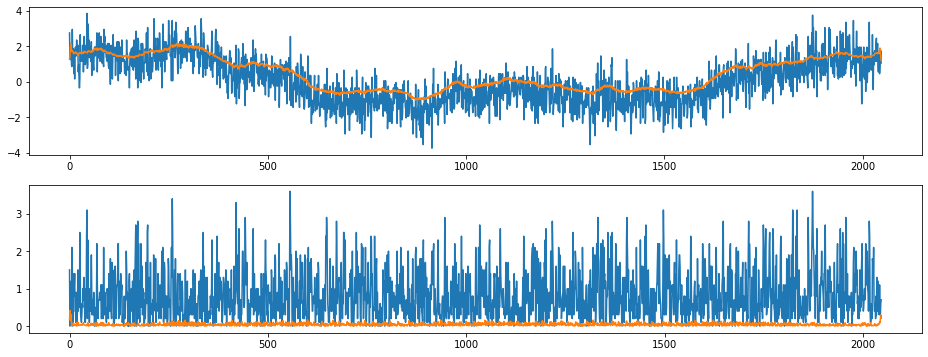

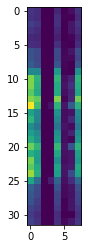

index:  76264
MAE:  0.713833780965797
n_bunches       229
bunch_index     267
bunch_number     52
Name: 1788442, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7468/instability_data/07468_Inst_B1H_Q7_20181123_19h21m50s.h5


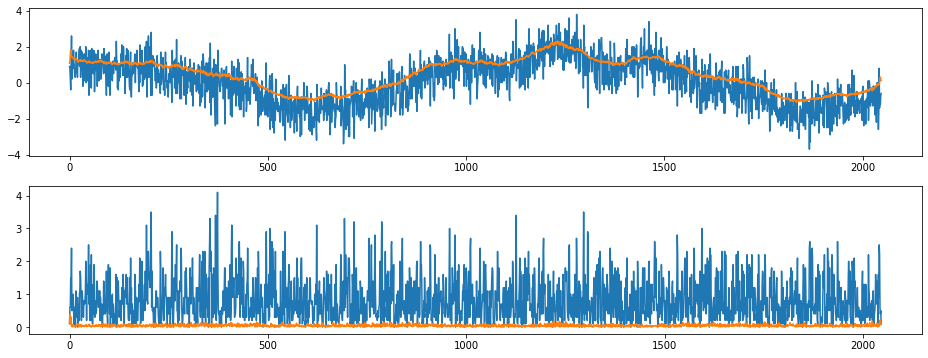

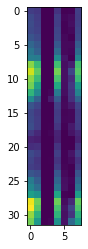

index:  323916
MAE:  0.71467271985166
n_bunches       2556
bunch_index     2527
bunch_number    1873
Name: 2338447, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6696/instability_data/06696_Inst_B1H_Q7_20180518_10h05m14s.h5


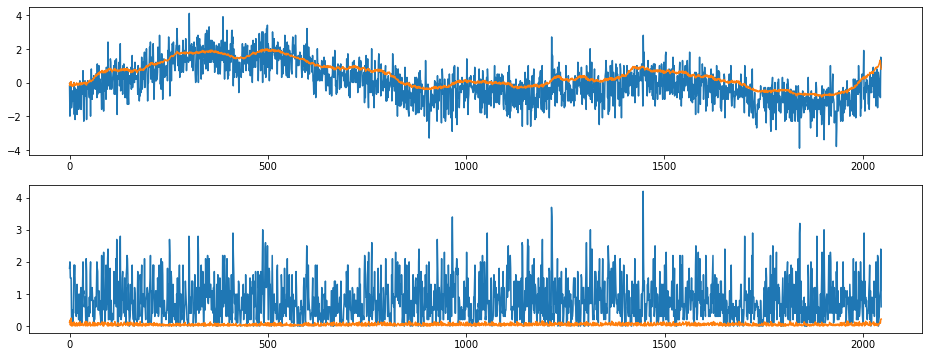

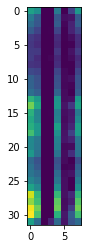

index:  80310
MAE:  0.7170491603719711
n_bunches       540
bunch_index     122
bunch_number     66
Name: 4119931, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7015/instability_data/07015_Inst_B1H_Q7_20180803_06h18m14s.h5


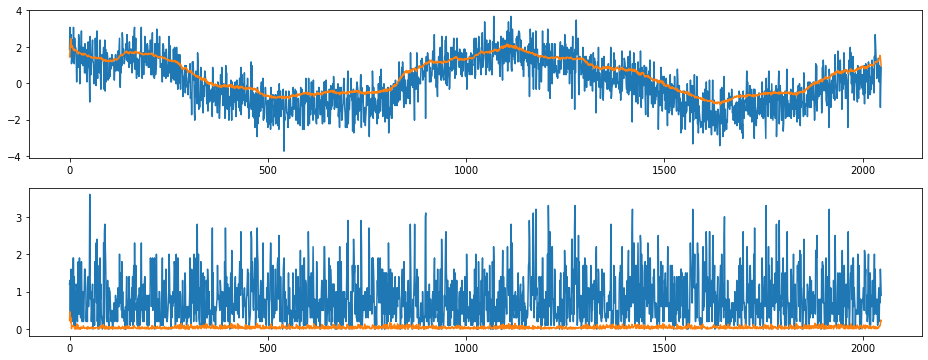

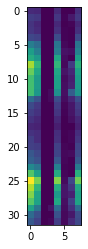

In [36]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]
    
    encoding_output = encoding_model(train_dataset[max_MAE_indices[left_most]][None, :])

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Latent space encoding of anomalous signals

index:  356849
MAE:  141.8414837383374
n_bunches       780
bunch_index     603
bunch_number    407
Name: 719870, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6761/instability_data/06761_Inst_B1H_Q7_20180605_19h10m35s.h5


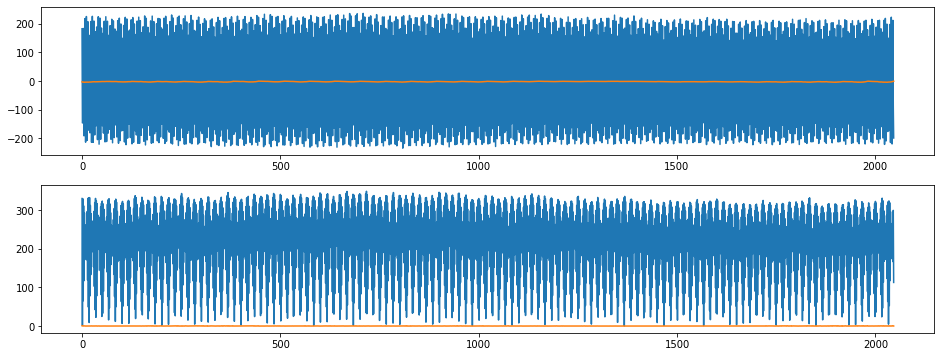

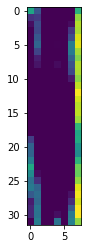

index:  355586
MAE:  139.5113127550663
n_bunches       108
bunch_index      77
bunch_number     28
Name: 7725680, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7090/instability_data/07090_Inst_B1H_Q7_20180826_10h03m32s.h5


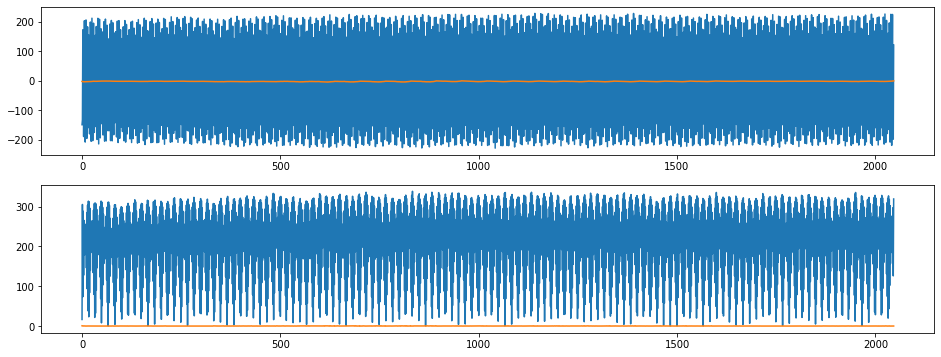

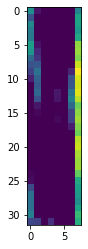

index:  359817
MAE:  136.8761223933776
n_bunches        656
bunch_index     2276
bunch_number     432
Name: 2986712, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6404/instability_data/06404_Inst_B1H_Q7_20171121_18h23m14s.h5


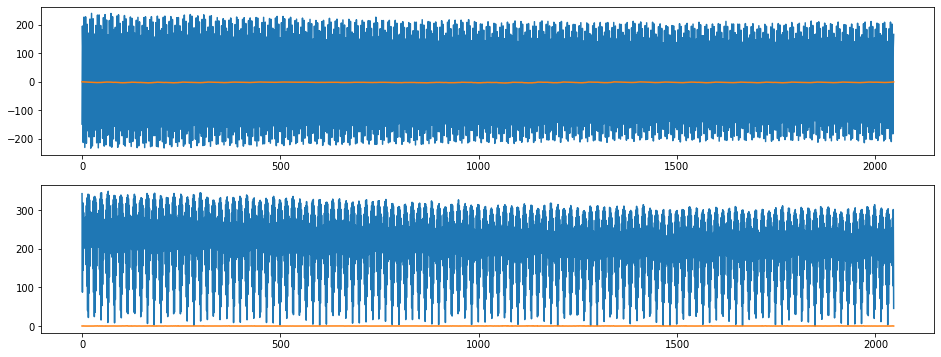

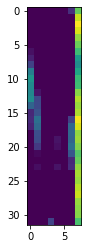

index:  353559
MAE:  129.23259305610554
n_bunches       1308
bunch_index     1284
bunch_number     930
Name: 1846339, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7056/instability_data/07056_Inst_B1H_Q7_20180815_03h07m56s.h5


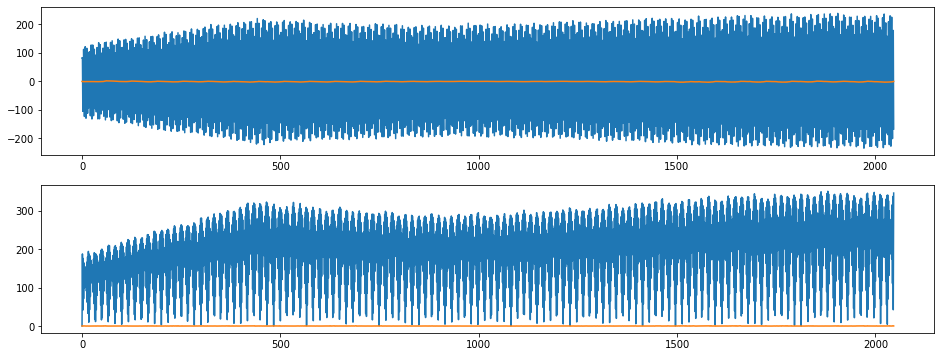

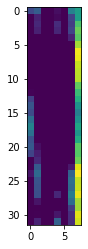

index:  332842
MAE:  115.66085810822551
n_bunches       1452
bunch_index      702
bunch_number     292
Name: 275332, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180706_11h41m15s.h5


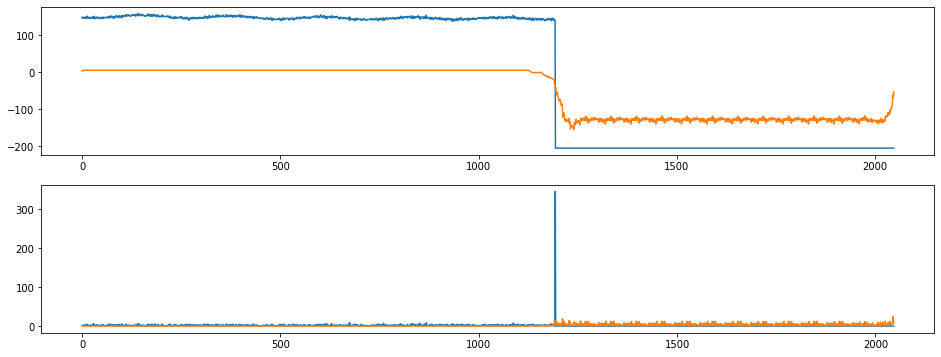

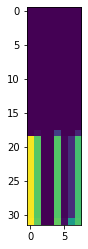

index:  127570
MAE:  109.40146021306282
n_bunches       1836
bunch_index     1225
bunch_number     649
Name: 3307945, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6271/instability_data/06271_Inst_B1H_Q7_20171004_11h54m55s.h5


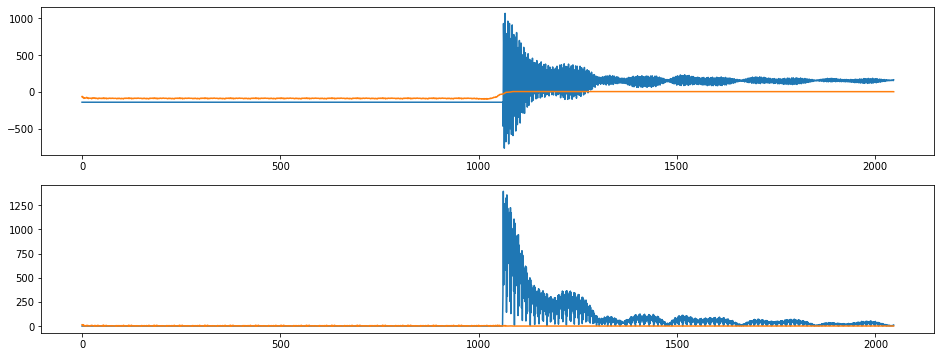

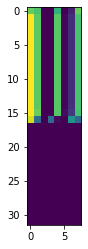

index:  357938
MAE:  97.59882953064516
n_bunches       418
bunch_index     452
bunch_number     92
Name: 1839325, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7489/instability_data/07489_Inst_B1H_Q7_20181201_17h24m18s.h5


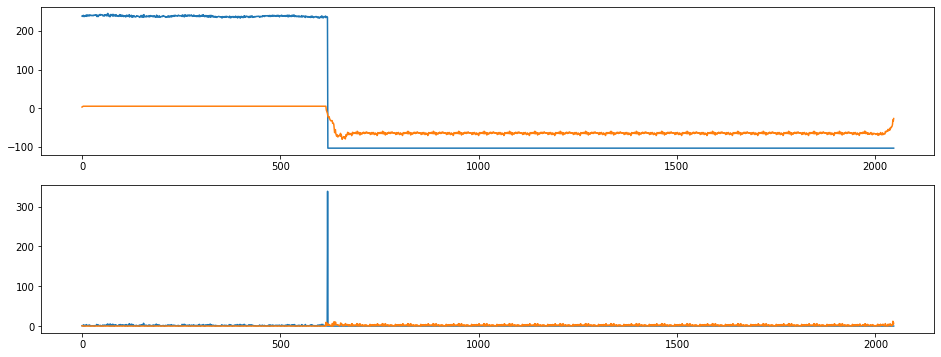

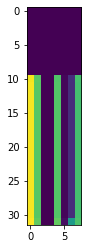

index:  154239
MAE:  91.65181968334363
n_bunches       1116
bunch_index     1019
bunch_number     392
Name: 7574998, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6587/instability_data/06587_Inst_B1H_Q7_20180421_15h05m14s.h5


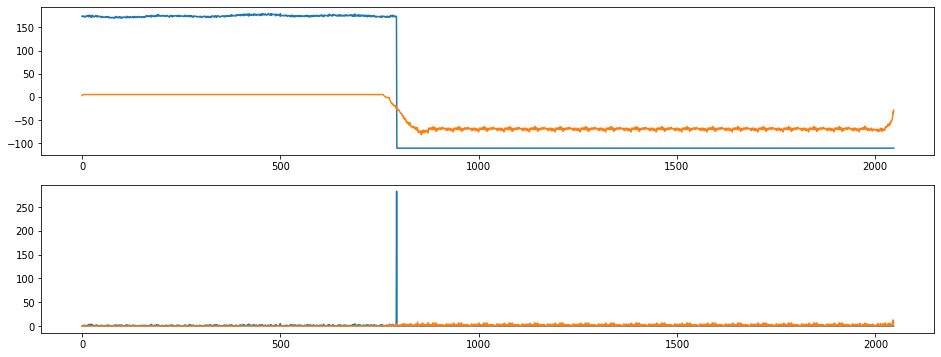

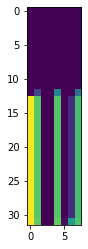

index:  287663
MAE:  90.50422252526621
n_bunches       252
bunch_index     326
bunch_number    225
Name: 3528520, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7063/instability_data/07063_Inst_B1H_Q7_20180818_14h46m15s.h5


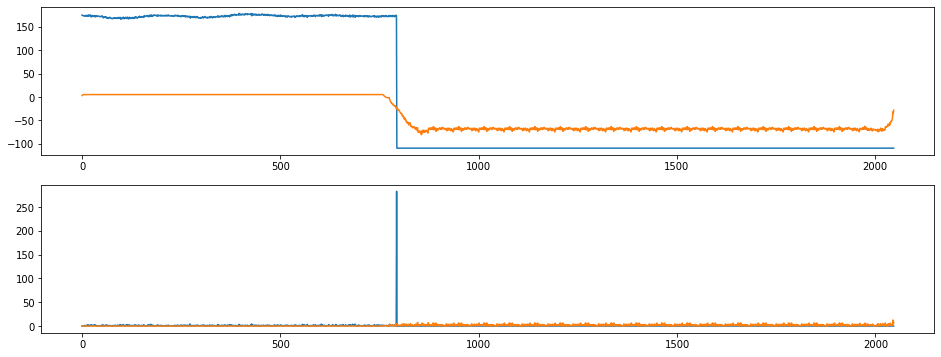

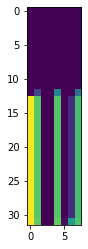

index:  144944
MAE:  87.65530672851601
n_bunches       1916
bunch_index       81
bunch_number      35
Name: 500832, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6253/instability_data/06253_Inst_B1H_Q7_20170929_03h32m15s.h5


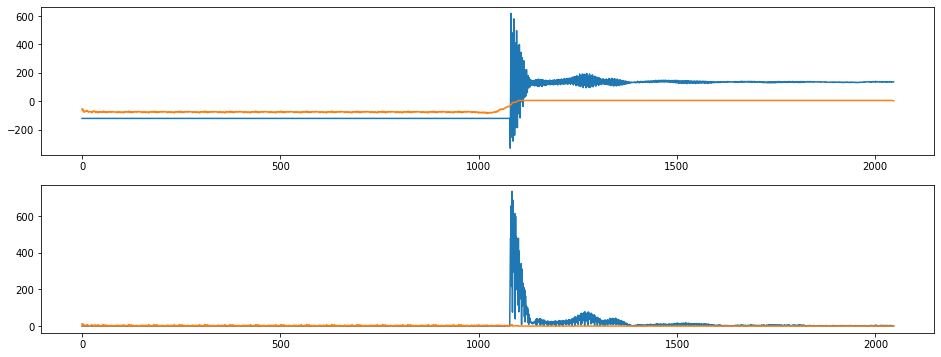

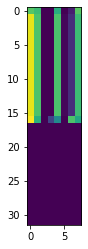

index:  319413
MAE:  84.1859959804977
n_bunches       2556
bunch_index     2990
bunch_number    2223
Name: 7362179, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7033/instability_data/07033_Inst_B1H_Q7_20180807_08h37m15s.h5


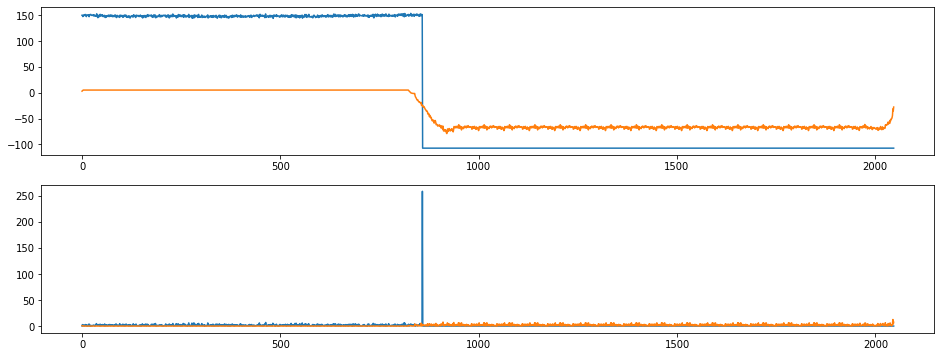

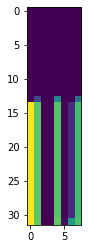

index:  291616
MAE:  76.8637002886564
n_bunches       987
bunch_index     482
bunch_number    148
Name: 5192384, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6901/instability_data/06901_Inst_B1H_Q7_20180708_03h13m49s.h5


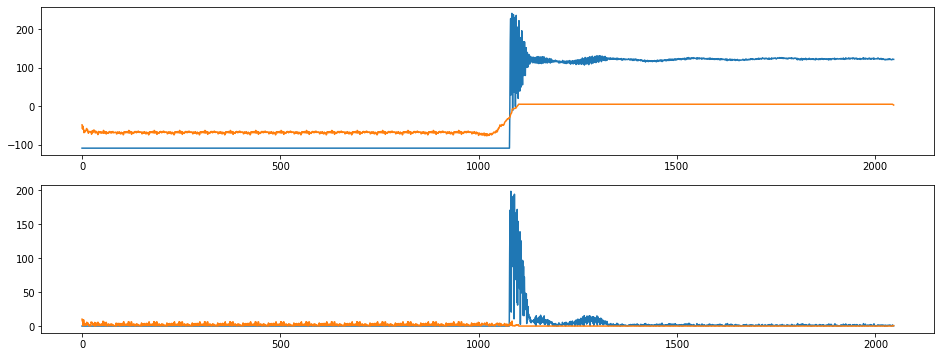

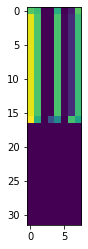

index:  209985
MAE:  76.61896989449743
n_bunches       1868
bunch_index      404
bunch_number     209
Name: 9684962, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6364/instability_data/06364_Inst_B1H_Q7_20171106_03h29m26s.h5


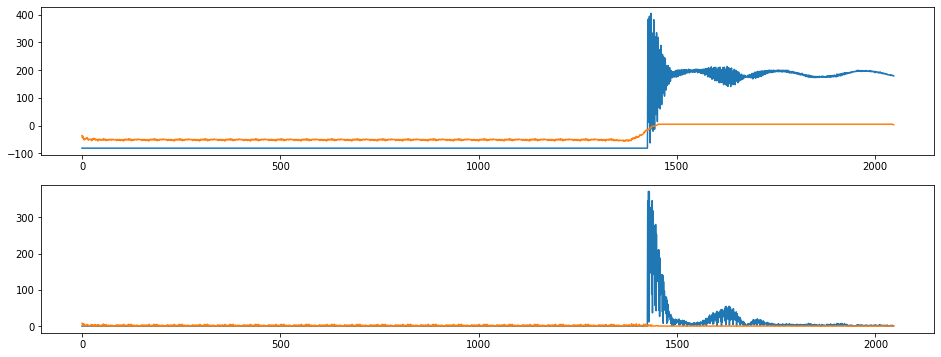

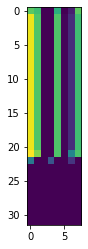

index:  256483
MAE:  74.47754809682957
n_bunches       1836
bunch_index     3034
bunch_number    1596
Name: 1571564, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6390/instability_data/06390_Inst_B1H_Q7_20171115_23h00m14s.h5


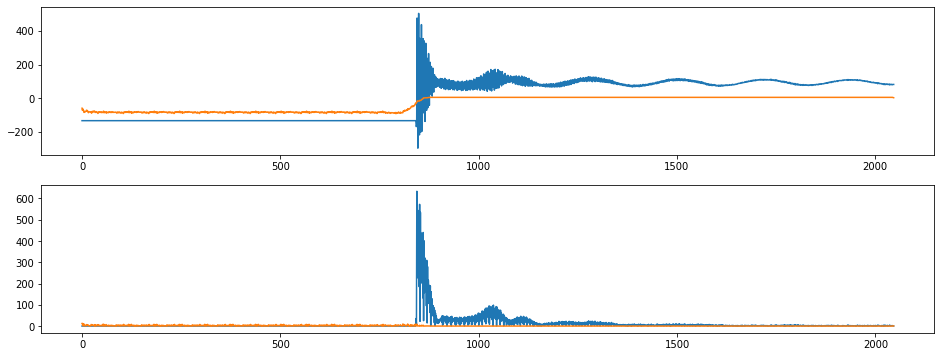

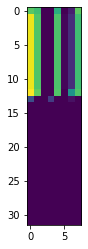

index:  141907
MAE:  74.16893488322967
n_bunches       686
bunch_index     698
bunch_number    165
Name: 5368539, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6238/instability_data/06238_Inst_B1H_Q7_20170923_21h24m23s.h5


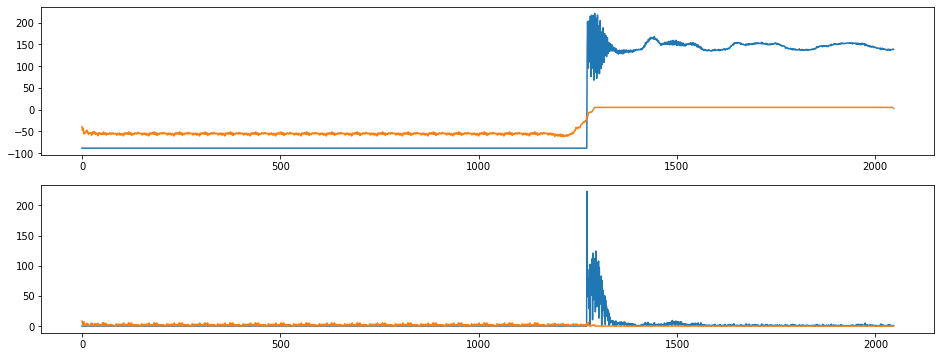

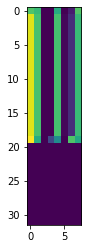

index:  251272
MAE:  72.2845467845851
n_bunches        156
bunch_index     2320
bunch_number      80
Name: 8462601, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6200/instability_data/06200_Inst_B1H_Q7_20170914_23h02m24s.h5


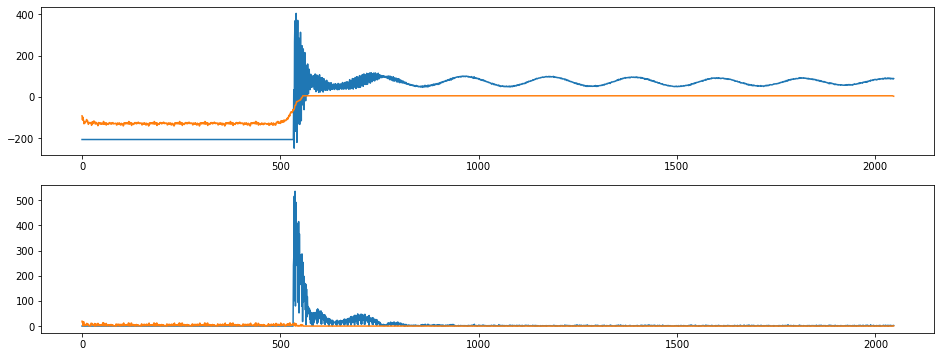

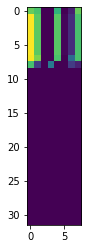

index:  354521
MAE:  69.8823590381362
n_bunches       1452
bunch_index     2888
bunch_number    1223
Name: 3851128, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6891/instability_data/06891_Inst_B1H_Q7_20180706_22h47m14s.h5


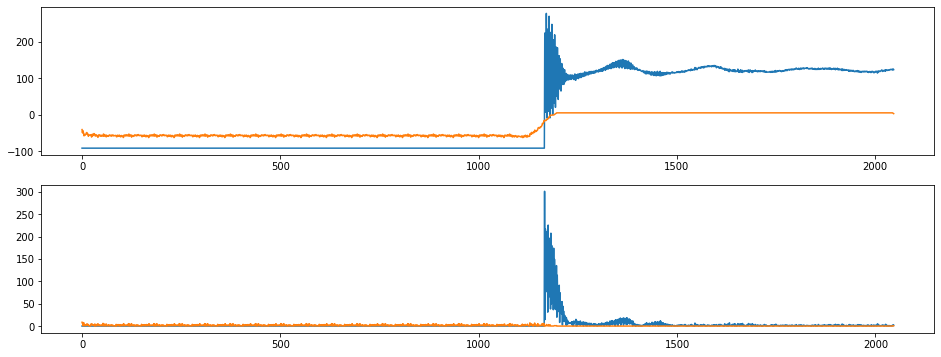

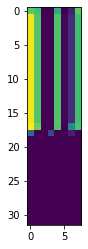

index:  198601
MAE:  68.30235390270246
n_bunches       1068
bunch_index     1339
bunch_number     978
Name: 1512706, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6931/instability_data/06931_Inst_B1H_Q7_20180716_16h33m51s.h5


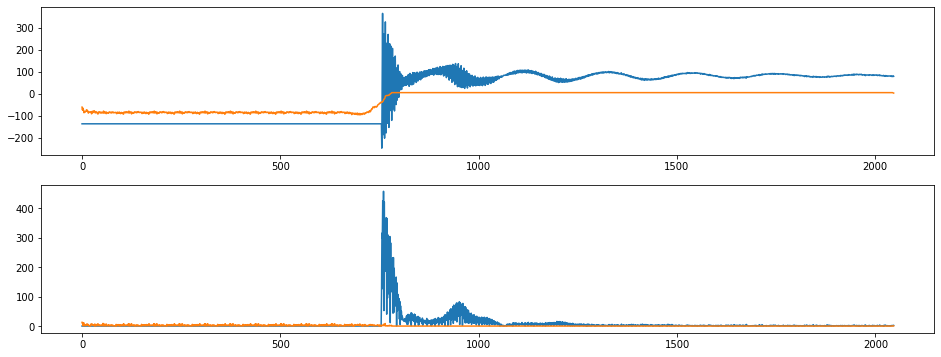

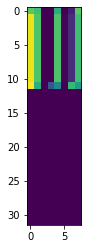

index:  333794
MAE:  66.97597064988223
n_bunches       2556
bunch_index     1726
bunch_number    1259
Name: 2532576, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6696/instability_data/06696_Inst_B1H_Q7_20180518_05h36m14s.h5


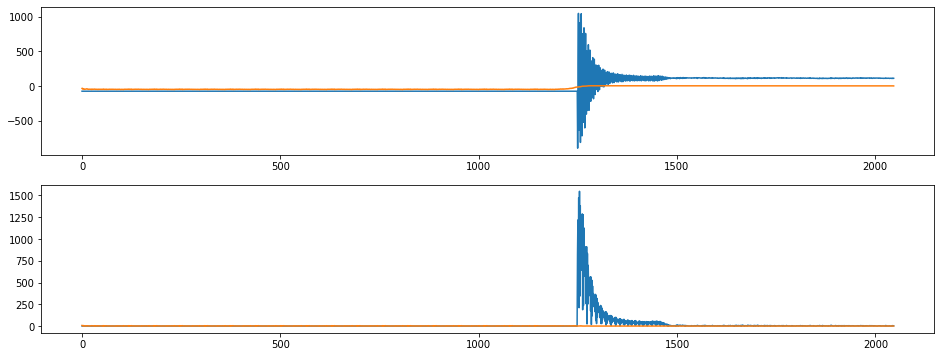

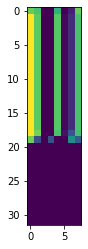

index:  230390
MAE:  66.93893930577325
n_bunches       1004
bunch_index     1810
bunch_number     968
Name: 4478789, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6337/instability_data/06337_Inst_B1H_Q7_20171027_05h27m16s.h5


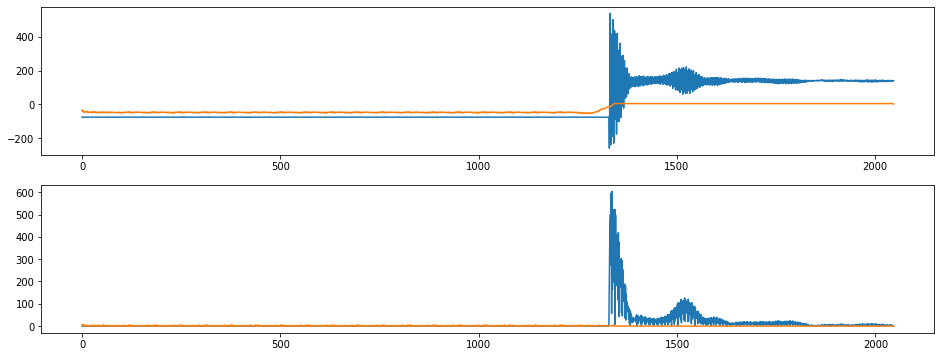

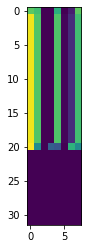

index:  198383
MAE:  66.05968390504131
n_bunches        756
bunch_index     1067
bunch_number     277
Name: 11421586, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6857/instability_data/06857_Inst_B1H_Q7_20180628_06h13m14s.h5


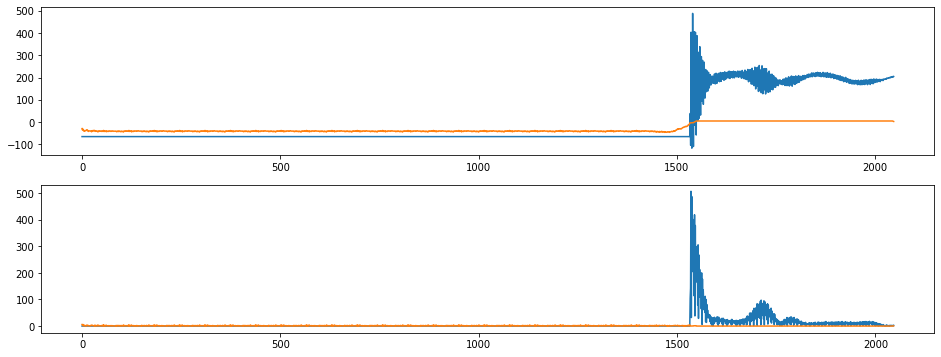

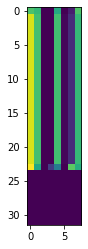

index:  329619
MAE:  65.23076268709265
n_bunches        444
bunch_index     2281
bunch_number     426
Name: 790139, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7448/instability_data/07448_Inst_B1H_Q7_20181116_07h28m59s.h5


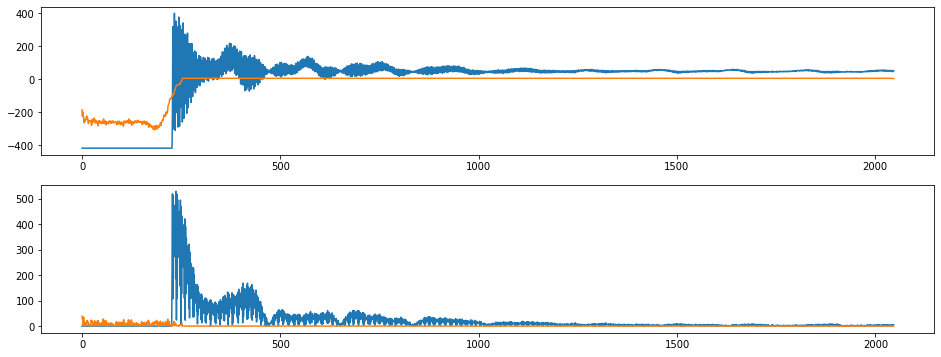

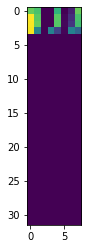

index:  219975
MAE:  64.27847910488491
n_bunches       1212
bunch_index      518
bunch_number     372
Name: 6513104, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6773/instability_data/06773_Inst_B1H_Q7_20180610_07h25m14s.h5


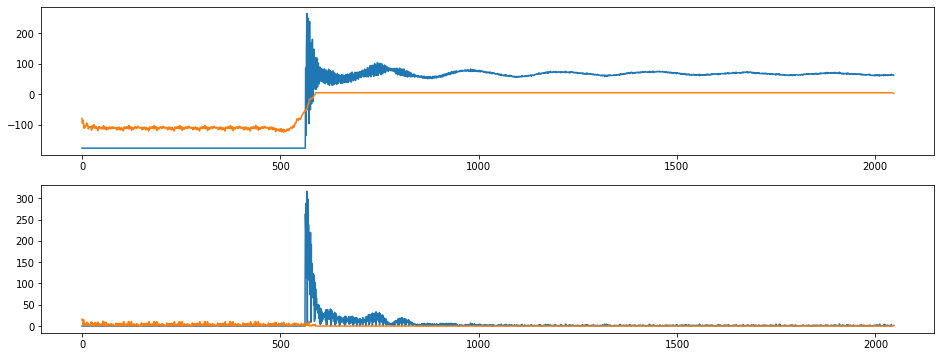

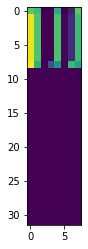

index:  94328
MAE:  63.06083125160076
n_bunches       300
bunch_index     281
bunch_number    185
Name: 6787595, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6609/instability_data/06609_Inst_B1H_Q7_20180424_04h27m46s.h5


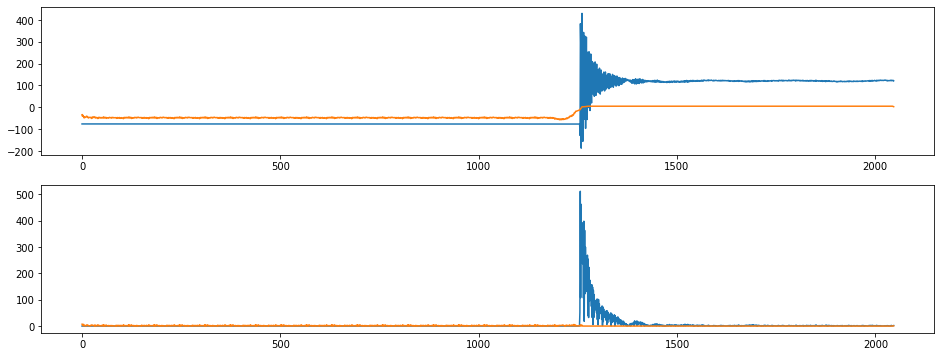

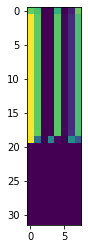

index:  53874
MAE:  62.904894854512534
n_bunches       157
bunch_index     243
bunch_number     56
Name: 2652488, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6434/instability_data/06434_Inst_B1H_Q7_20171129_17h15m14s.h5


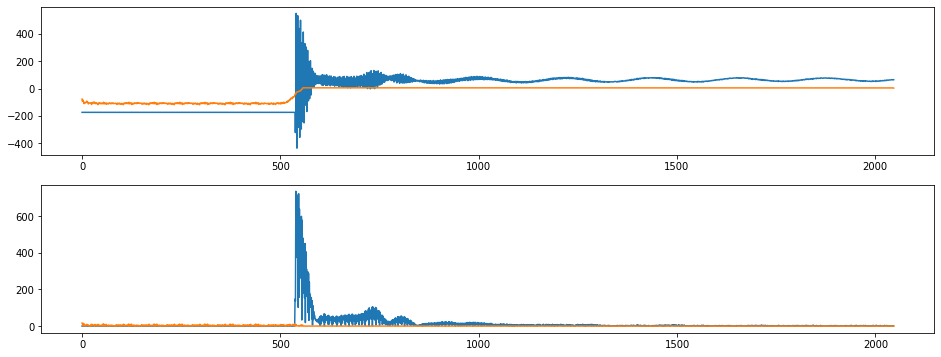

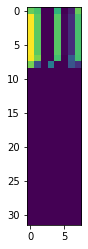

index:  232240
MAE:  62.29018325746874
n_bunches       2556
bunch_index     2988
bunch_number    2221
Name: 8749682, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7052/instability_data/07052_Inst_B1H_Q7_20180813_16h43m15s.h5


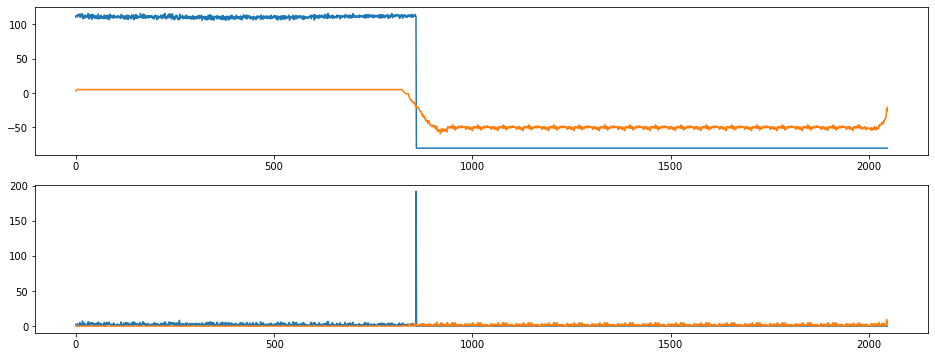

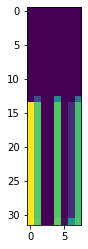

index:  100411
MAE:  59.78044052143669
n_bunches       1868
bunch_index     2640
bunch_number    1407
Name: 1372110, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6337/instability_data/06337_Inst_B1H_Q7_20171027_11h07m14s.h5


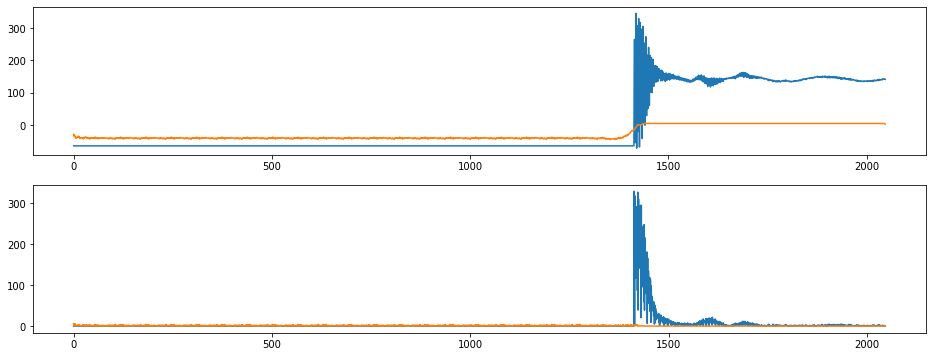

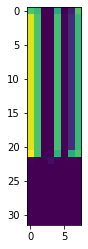

index:  106116
MAE:  58.78990552532632
n_bunches       636
bunch_index     356
bunch_number    236
Name: 8422061, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6662/instability_data/06662_Inst_B1H_Q7_20180509_21h41m36s.h5


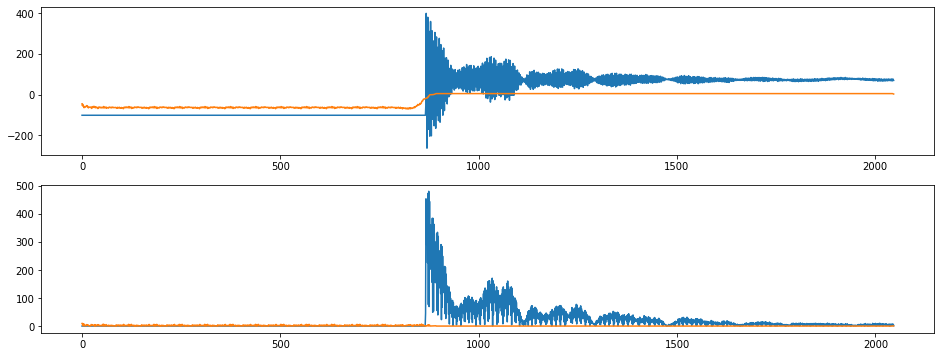

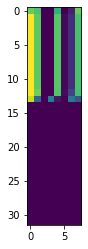

index:  406521
MAE:  58.0406413186749
n_bunches        924
bunch_index     1237
bunch_number     914
Name: 8758828, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7239/instability_data/07239_Inst_B1H_Q7_20180930_12h14m43s.h5


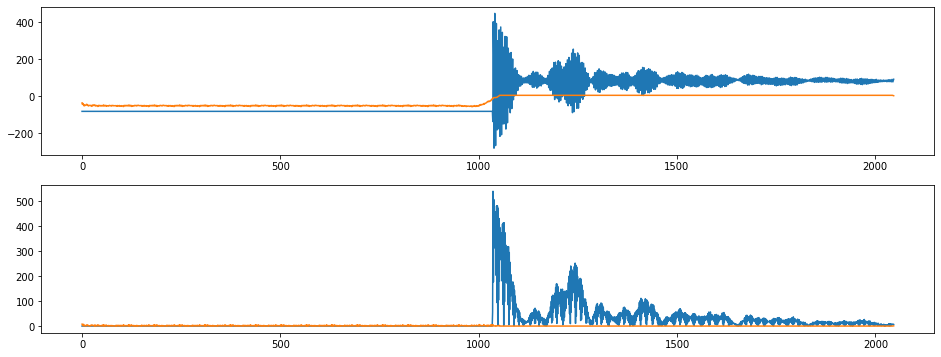

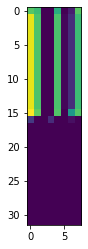

index:  287624
MAE:  57.48260950239492
n_bunches       2556
bunch_index     1184
bunch_number     868
Name: 7929806, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7033/instability_data/07033_Inst_B1H_Q7_20180807_13h17m14s.h5


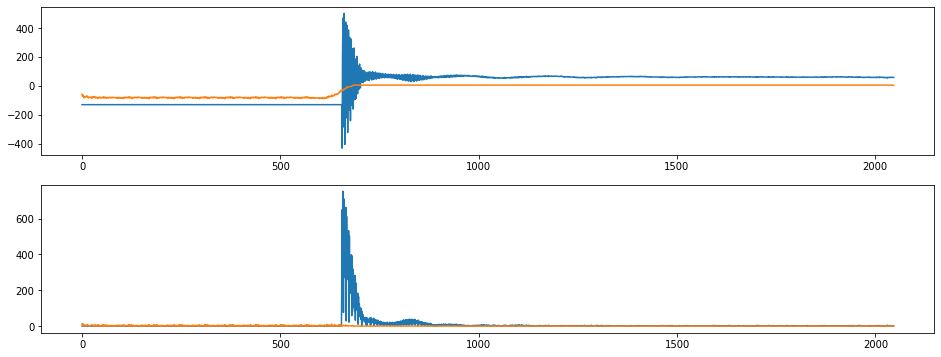

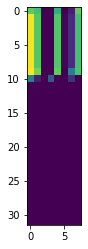

index:  80079
MAE:  56.89407284791233
n_bunches       636
bunch_index     153
bunch_number     78
Name: 8388223, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6710/instability_data/06710_Inst_B1H_Q7_20180521_12h36m20s.h5


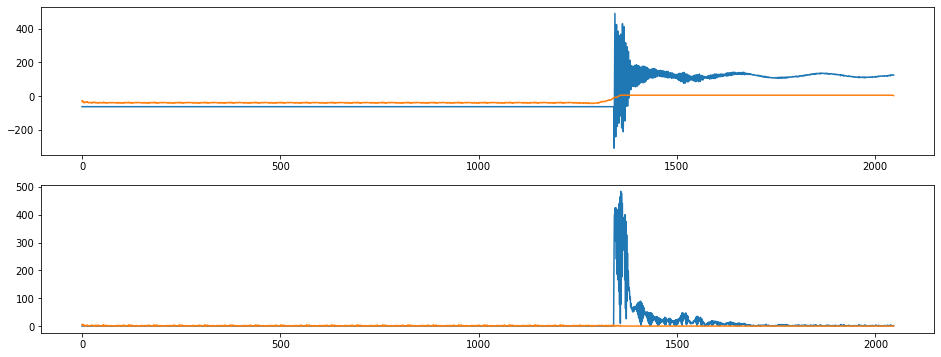

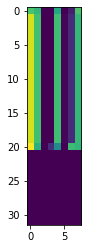

index:  256997
MAE:  55.804192168067665
n_bunches       1020
bunch_index     1161
bunch_number     847
Name: 10775016, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6457/instability_data/06457_Inst_B1H_Q7_20171203_18h49m14s.h5


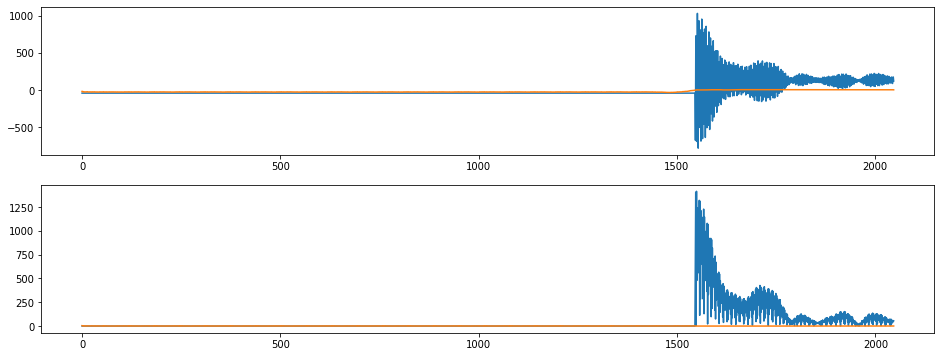

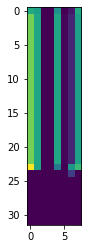

index:  189977
MAE:  55.442906232533275
n_bunches       780
bunch_index     489
bunch_number    263
Name: 186006, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6362/instability_data/06362_Inst_B1H_Q7_20171104_17h37m09s.h5


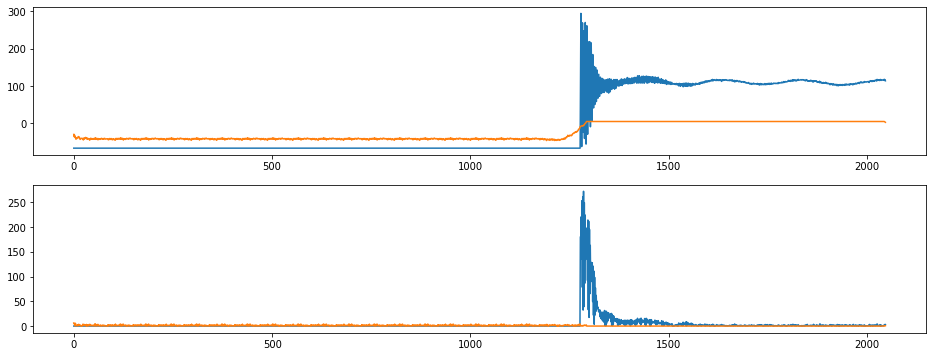

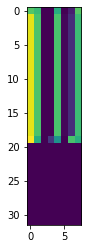

index:  357250
MAE:  54.65924142804215
n_bunches       908
bunch_index     400
bunch_number    180
Name: 4823608, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6398/instability_data/06398_Inst_B1H_Q7_20171119_21h12m37s.h5


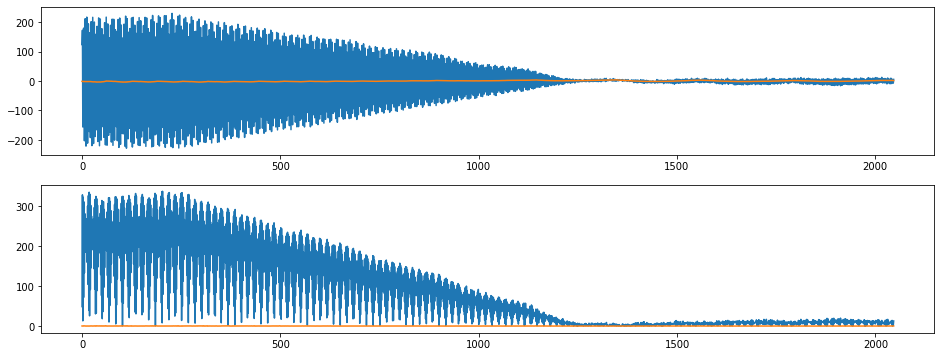

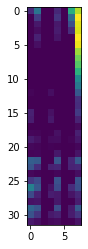

index:  360132
MAE:  54.16634257741971
n_bunches       2556
bunch_index      337
bunch_number     217
Name: 5687012, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6696/instability_data/06696_Inst_B1H_Q7_20180518_08h29m13s.h5


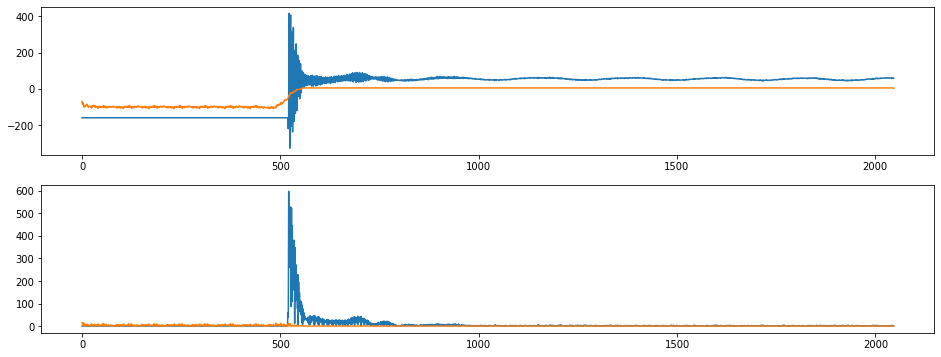

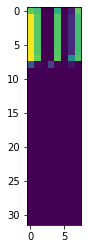

index:  235911
MAE:  54.09701189207699
n_bunches       1868
bunch_index     1837
bunch_number     984
Name: 785642, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6364/instability_data/06364_Inst_B1H_Q7_20171107_02h26m14s.h5


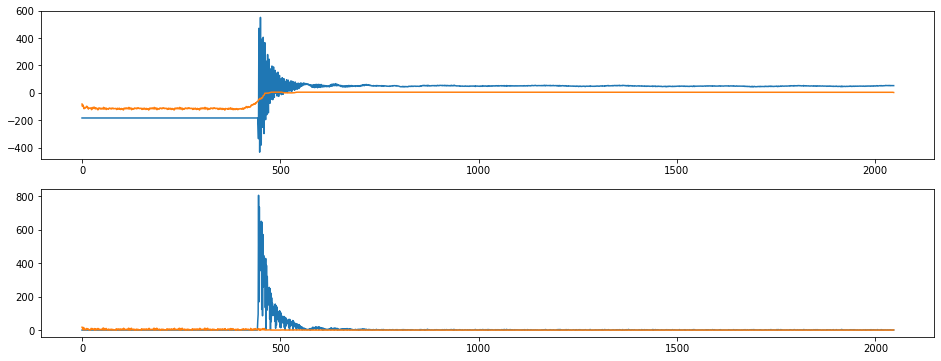

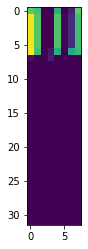

index:  266394
MAE:  53.25259776021121
n_bunches       843
bunch_index     608
bunch_number    260
Name: 10361522, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6901/instability_data/06901_Inst_B1H_Q7_20180708_03h09m39s.h5


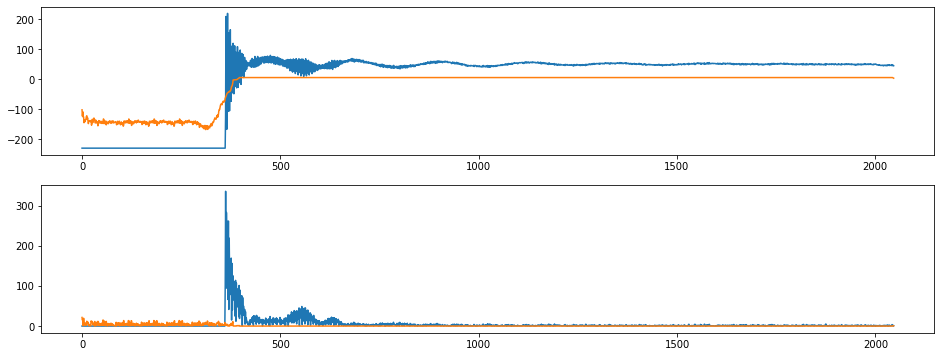

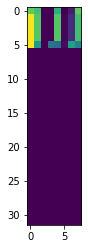

index:  263941
MAE:  53.10048559934366
n_bunches       1227
bunch_index     2251
bunch_number     815
Name: 1400227, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6620/instability_data/06620_Inst_B1H_Q7_20180428_23h40m15s.h5


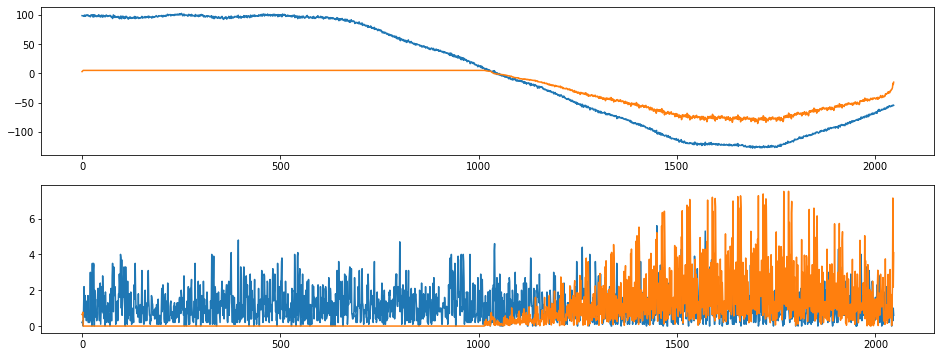

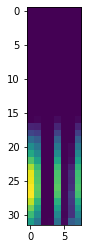

index:  403210
MAE:  52.555803761305285
n_bunches        228
bunch_index     2594
bunch_number     176
Name: 3993656, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6220/instability_data/06220_Inst_B1H_Q7_20170917_22h45m14s.h5


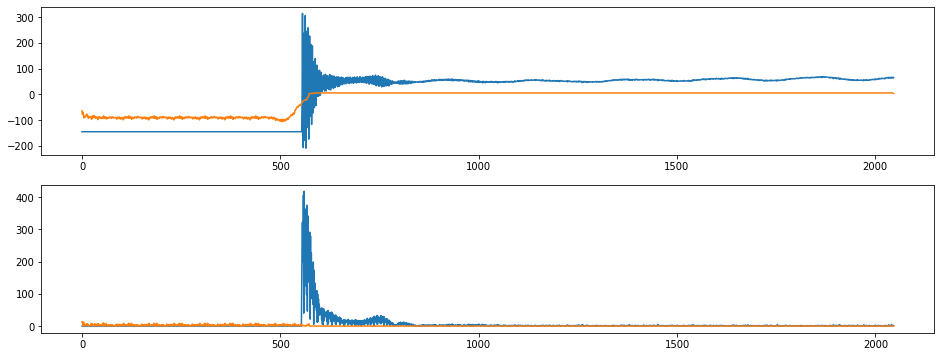

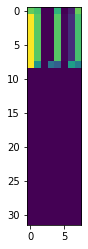

index:  66927
MAE:  52.36154677332379
n_bunches       636
bunch_index     123
bunch_number     67
Name: 10256191, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7088/instability_data/07088_Inst_B1H_Q7_20180826_04h24m08s.h5


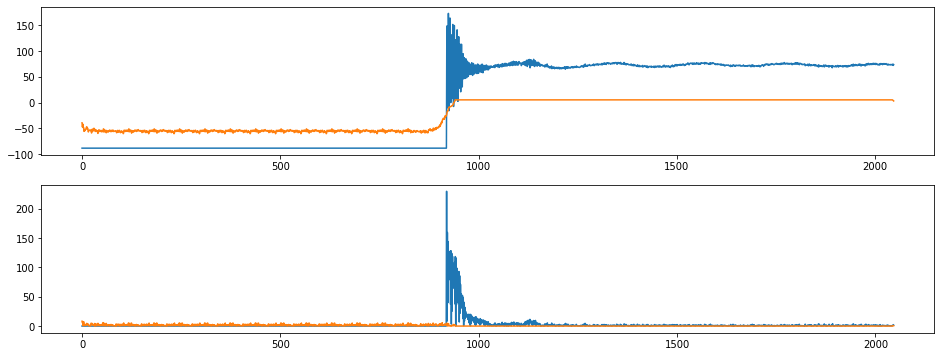

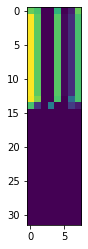

index:  281045
MAE:  50.66621972345747
n_bunches       636
bunch_index     597
bunch_number    420
Name: 4634930, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6925/instability_data/06925_Inst_B1H_Q7_20180715_16h16m03s.h5


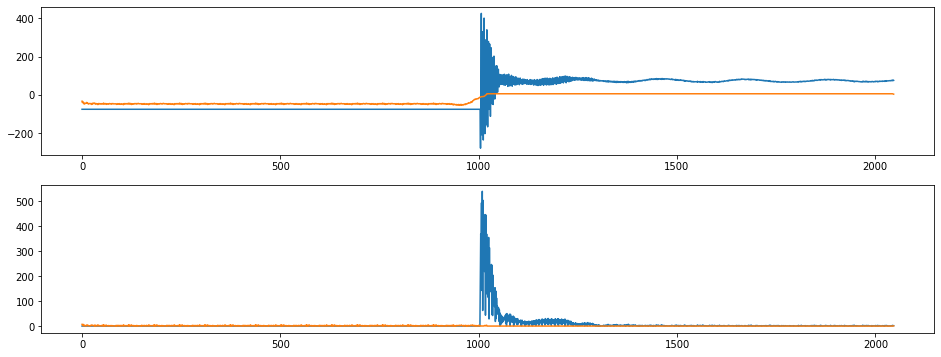

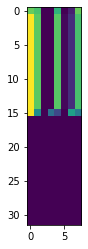

index:  73894
MAE:  50.40986989658559
n_bunches        518
bunch_index     2306
bunch_number     485
Name: 5433868, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6880/instability_data/06880_Inst_B1H_Q7_20180703_02h37m18s.h5


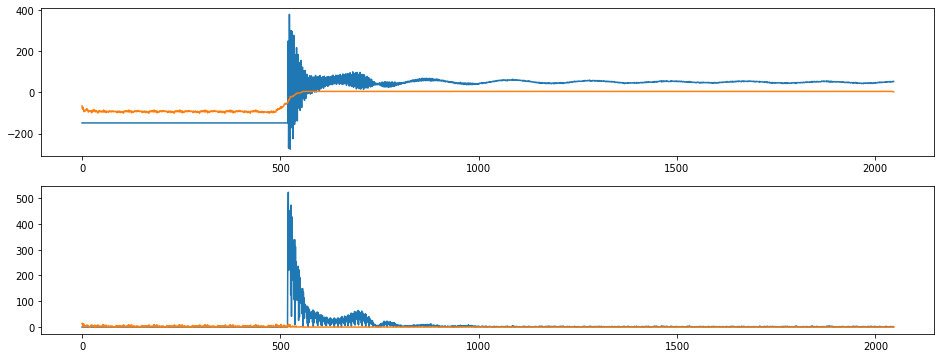

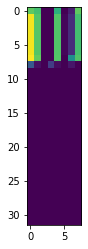

index:  259695
MAE:  50.169388748801424
n_bunches       2556
bunch_index      929
bunch_number     665
Name: 2117407, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/instability_data/06919_Inst_B1H_Q7_20180714_02h45m14s.h5


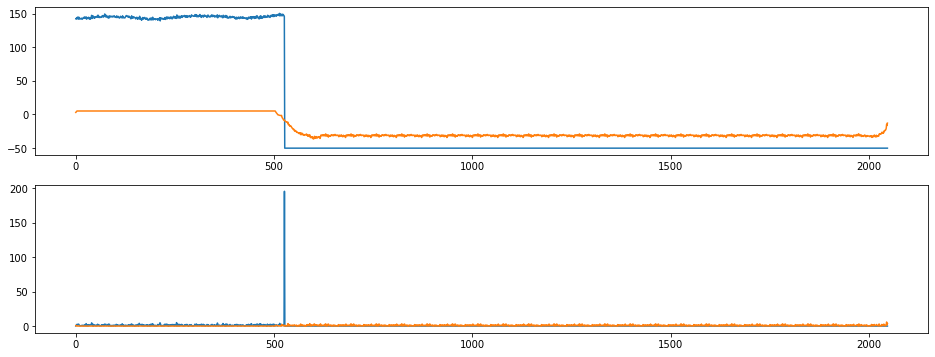

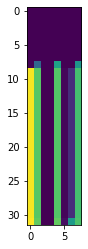

index:  108053
MAE:  48.71874416983337
n_bunches        733
bunch_index     2716
bunch_number     570
Name: 9908218, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7467/instability_data/07467_Inst_B1H_Q7_20181123_09h45m15s.h5


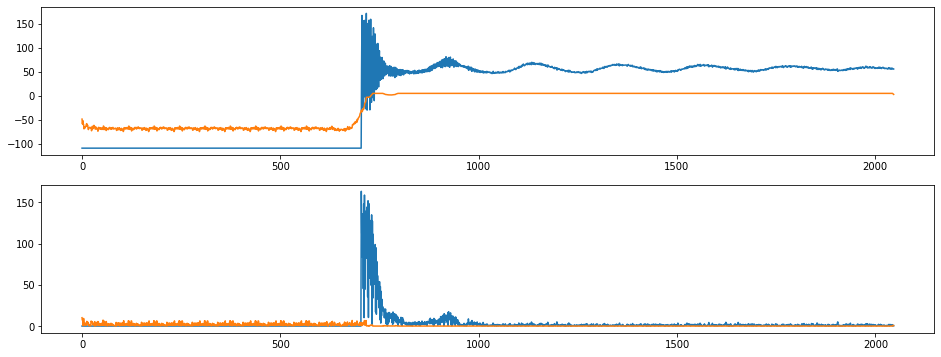

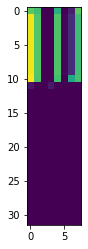

index:  292622
MAE:  48.64586819313409
n_bunches       636
bunch_index     259
bunch_number    153
Name: 2147839, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6757/instability_data/06757_Inst_B1H_Q7_20180604_04h19m15s.h5


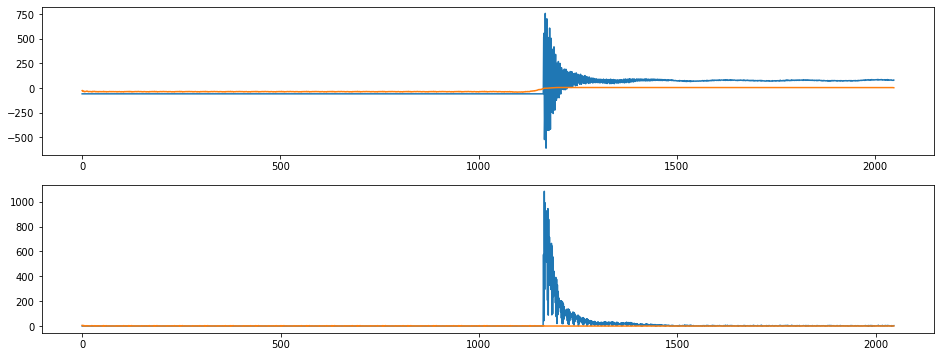

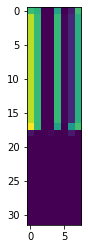

index:  96227
MAE:  46.147832830884724
n_bunches       1292
bunch_index     1090
bunch_number     357
Name: 8396979, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6384/instability_data/06384_Inst_B1H_Q7_20171112_23h11m14s.h5


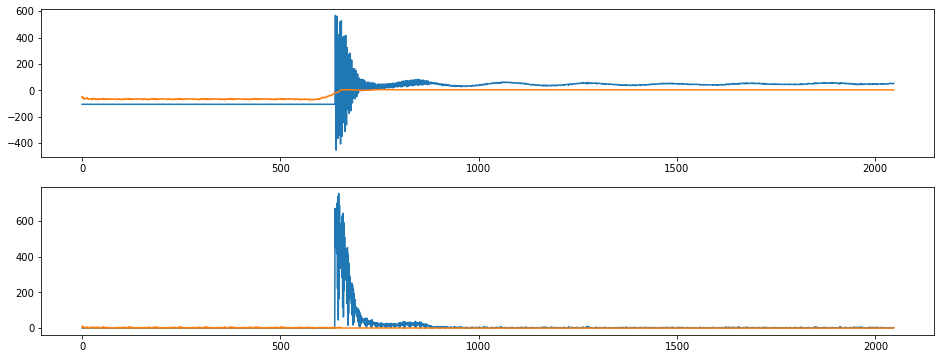

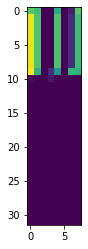

index:  49076
MAE:  45.88656778791337
n_bunches       924
bunch_index     630
bunch_number    446
Name: 9010756, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7045/instability_data/07045_Inst_B1H_Q7_20180811_23h21m15s.h5


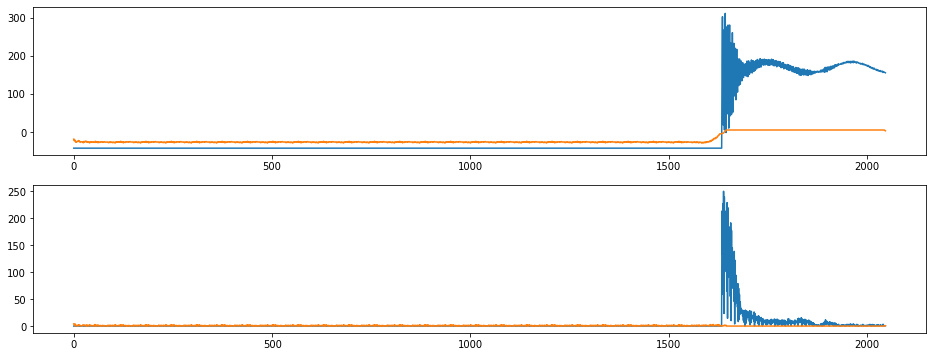

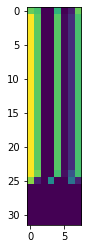

index:  249245
MAE:  43.408003219595415
n_bunches        648
bunch_index     1524
bunch_number     282
Name: 664795, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7448/instability_data/07448_Inst_B1H_Q7_20181116_09h27m15s.h5


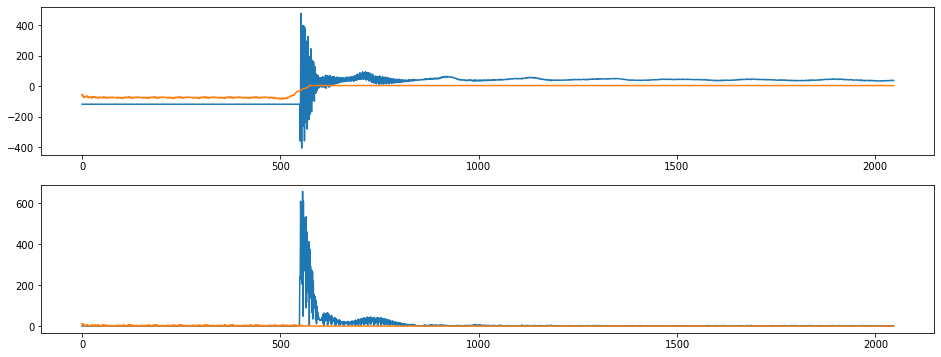

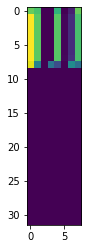

index:  395956
MAE:  43.34235331492964
n_bunches       780
bunch_index     503
bunch_number    270
Name: 2830700, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6347/instability_data/06347_Inst_B1H_Q7_20171030_11h04m14s.h5


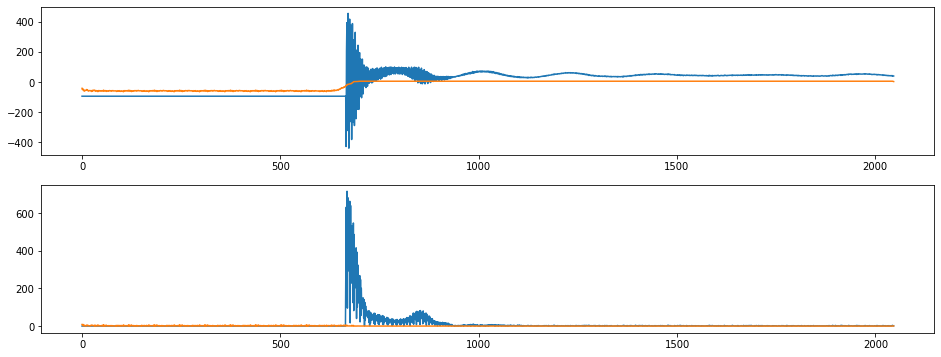

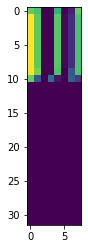

index:  2192
MAE:  43.25044696832192
n_bunches       355
bunch_index     682
bunch_number    143
Name: 8163933, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7470/instability_data/07470_Inst_B1H_Q7_20181124_09h43m02s.h5


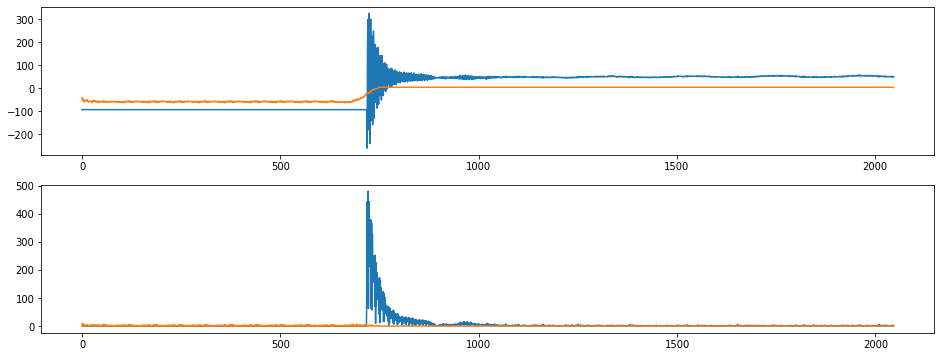

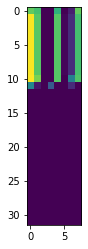

In [37]:
for i in range(50):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    
    encoding_output = encoding_model(train_dataset[anomalous_index][None, :])

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()